

Autor: Manuel Meniño Magán

Proyecto: 11MBIG TFM. Detección de anomalías en series temporales de tráfico de Internet. Aplicación en indicadores de red de Vodafone España

Descripción: En este cuaderno se prueban los diferentes modelos para detectar anomalías articiales


In [1]:
import requests
import io
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from google.colab import files
from google.colab import drive
import datetime
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics
from pandas.plotting import register_matplotlib_converters
from fbprophet import Prophet
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Importar datasets train y test a csv

Importar datasets previos

In [2]:
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!cp '/gdrive/My Drive/11MBIG TFM/SID Data/train_inet_vigo_202007.csv' serie_train.csv
!cp '/gdrive/My Drive/11MBIG TFM/SID Data/test_inet_vigo_202007.csv' serie_test.csv
!ls -la | grep .csv

-rw------- 1 root root  59078 Oct  4 11:18 serie_test.csv
-rw------- 1 root root 236882 Oct  4 11:18 serie_train.csv


In [69]:
serie_train = pd.read_csv('serie_train.csv', usecols=['timeStamp', 'total'])
serie_train.set_index(keys='timeStamp', inplace=True)
serie_test = pd.read_csv('serie_test.csv', usecols=['timeStamp', 'total'])
serie_test.set_index(keys='timeStamp', inplace=True)
serie_test.head()

total
timeStamp            
1595800800  55.256671
1595801100  55.490521
1595801400  53.201406
1595801700  52.884181
1595802000  52.357252

##Crear anomalías

Se crea una anomalía en el dataset de test de -5 Gbps de 2 horas de duración en hora pico, 29/07 de 21:00 a 23:00

Se crea una 2ªanomalía en el dataset de test de +3 Gbps de 3 horas de duración en hora pico, 31/07 de 15:00 a 18:00

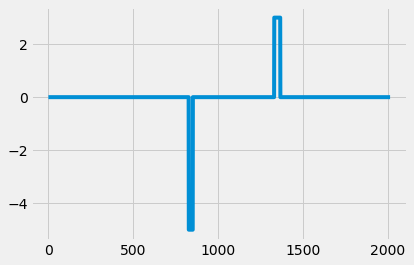

In [70]:
epoch_week31_start=1595800800
epoch_start_anomalia1 = 1596056400-2*60*60
epoch_end_anomalia1 = 1596063600-2*60*60
epoch_start_anomalia2 = 1596207600-2*60*60
epoch_end_anomalia2 = 1596218400-2*60*60
anomalia = [0] * len(serie_test)
inicio1 = int(np.where(serie_test.index==epoch_start_anomalia1)[0])
fin1 = int(np.where(serie_test.index==epoch_end_anomalia1)[0])
anomalia[inicio1:fin1] = [-5] * (fin1-inicio1)
inicio2 = int(np.where(serie_test.index==epoch_start_anomalia2)[0])
fin2 = int(np.where(serie_test.index==epoch_end_anomalia2)[0])
anomalia[inicio2:fin2] = [3] * (fin2-inicio2)
plt.plot(anomalia)

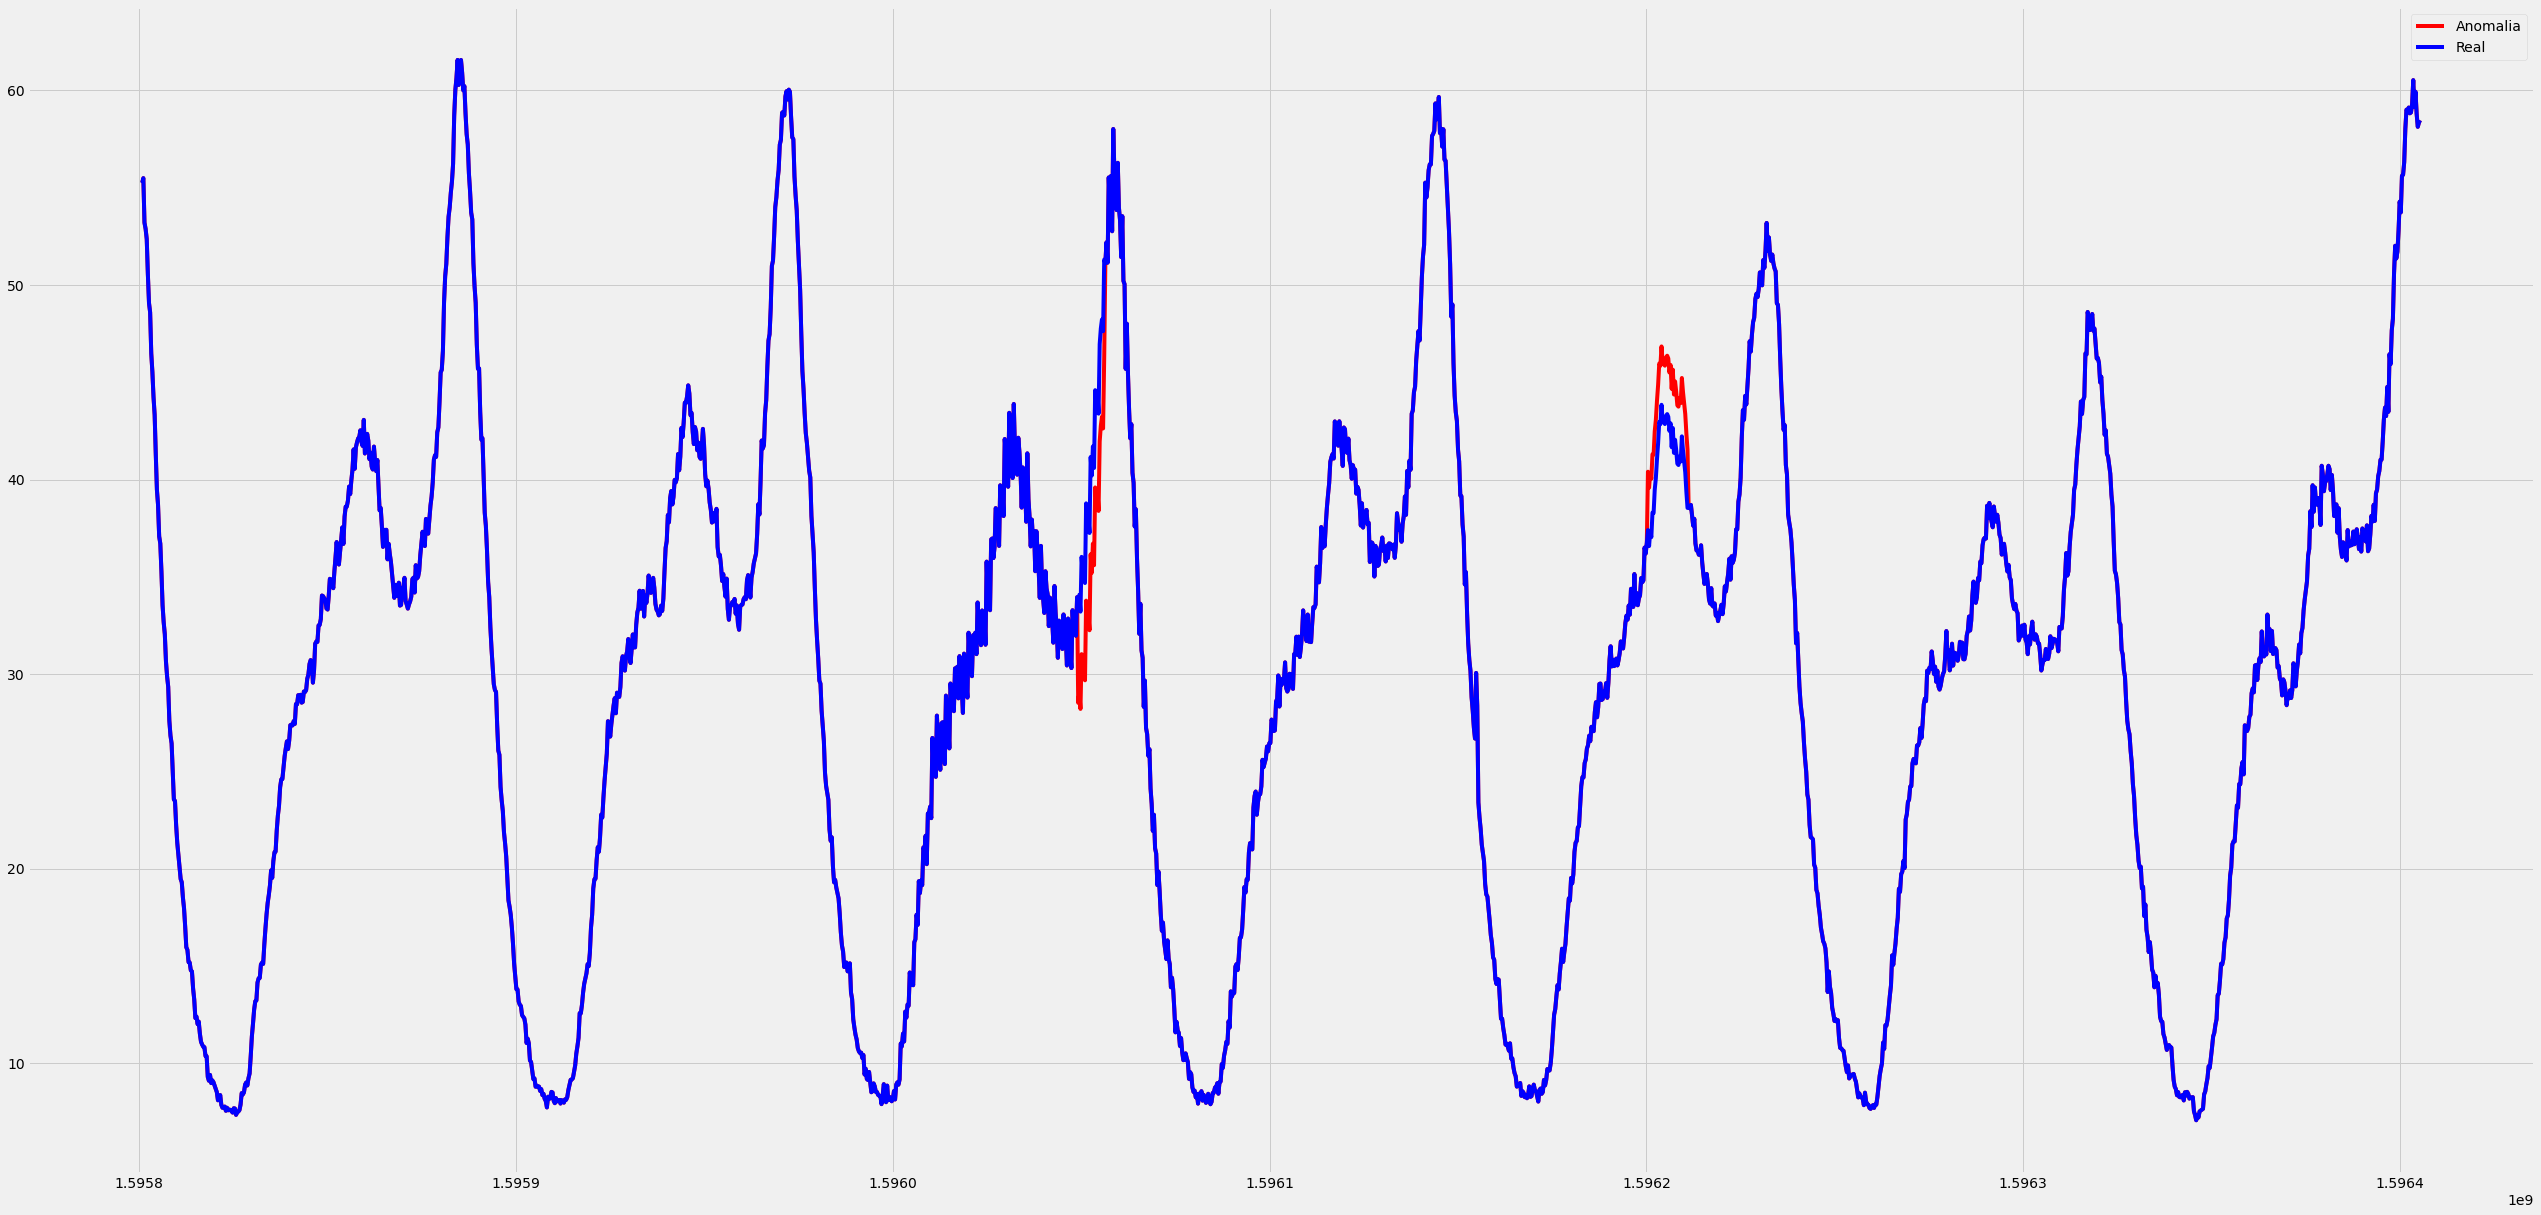

In [71]:
plt.figure(figsize=[40,20])
#plt.axvline(x=epoch_start_anomalia1, color='black')
#plt.axvline(x=epoch_end_anomalia1, color='black')
#plt.axvline(x=epoch_start_anomalia2, color='black')
#plt.axvline(x=epoch_end_anomalia2, color='black')
plt.plot(serie_test.index, serie_test['total']+anomalia, color='red', label='Anomalia')
plt.plot(serie_test.index, serie_test['total'], color='blue', label='Real')
plt.legend()
plt.show()

In [72]:
serie_test['total'] = serie_test['total'] + anomalia

##Cambiar TimeStamp a Date

In [73]:
serie_train.index = pd.to_datetime(serie_train.index, unit='s') + pd.Timedelta('02:00:00') #¡OJO! +2 por ser horario de verano. El timestamp está en horario UTC
serie_test.index = pd.to_datetime(serie_test.index, unit='s') + pd.Timedelta('02:00:00')
serie_test.head()

total
timeStamp                     
2020-07-27 00:00:00  55.256671
2020-07-27 00:05:00  55.490521
2020-07-27 00:10:00  53.201406
2020-07-27 00:15:00  52.884181
2020-07-27 00:20:00  52.357252

In [74]:
 epoch_start_anomalia1 = pd.to_datetime(epoch_start_anomalia1, unit='s') + pd.Timedelta('02:00:00')
 epoch_end_anomalia1 = pd.to_datetime(epoch_end_anomalia1, unit='s') + pd.Timedelta('02:00:00')
 epoch_start_anomalia2 = pd.to_datetime(epoch_start_anomalia2, unit='s') + pd.Timedelta('02:00:00')
 epoch_end_anomalia2 = pd.to_datetime(epoch_end_anomalia2, unit='s') + pd.Timedelta('02:00:00')

Variables temporales

In [26]:
epoch_week27_start=1593381600
epoch_week28_start=1593986400
epoch_week29_start=1594591200
epoch_week30_start=1595196000
epoch_week31_start=1595800800
epoch_week32_start=1596405600
epoch_hour = 60*60
epoch_day = 24 * epoch_hour
epoch_week = 7 * epoch_day
day_samples = int(epoch_day/300)
week_samples = int(epoch_week/300)

##Medidas de error

https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1

In [27]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def regression_results(y_true, y_pred):# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mape=mean_absolute_percentage_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    #print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    #print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,2))
    print('MSE: ', round(mse,2))
    #print('RMSE: ', round(np.sqrt(mse),4))
    print('MAPE: ', round(mape,2))
    

##Seasonal Naïve

Se toma el valor de la semana anterior a la de test

In [28]:
pred_snaive = serie_train.iloc[-2016:]
pred_snaive

total
timeStamp                     
2020-07-20 00:00:00  53.391514
2020-07-20 00:05:00  51.633795
2020-07-20 00:10:00  53.253416
2020-07-20 00:15:00  52.714763
2020-07-20 00:20:00  51.100041
...                        ...
2020-07-26 23:35:00  59.284297
2020-07-26 23:40:00  58.385666
2020-07-26 23:45:00  58.152342
2020-07-26 23:50:00  57.767017
2020-07-26 23:55:00  56.195818

[2016 rows x 1 columns]

In [29]:
#Calculo de errores y medidas de error
errores_snaive =(serie_test.values - pred_snaive.values)
print('Resultados Test Seasonal Naïve (1 semana)')
regression_results(serie_test.values, pred_snaive.values)

Resultados Test Seasonal Naïve (1 semana)
MAE:  1.46
MSE:  4.47
MAPE:  4.88


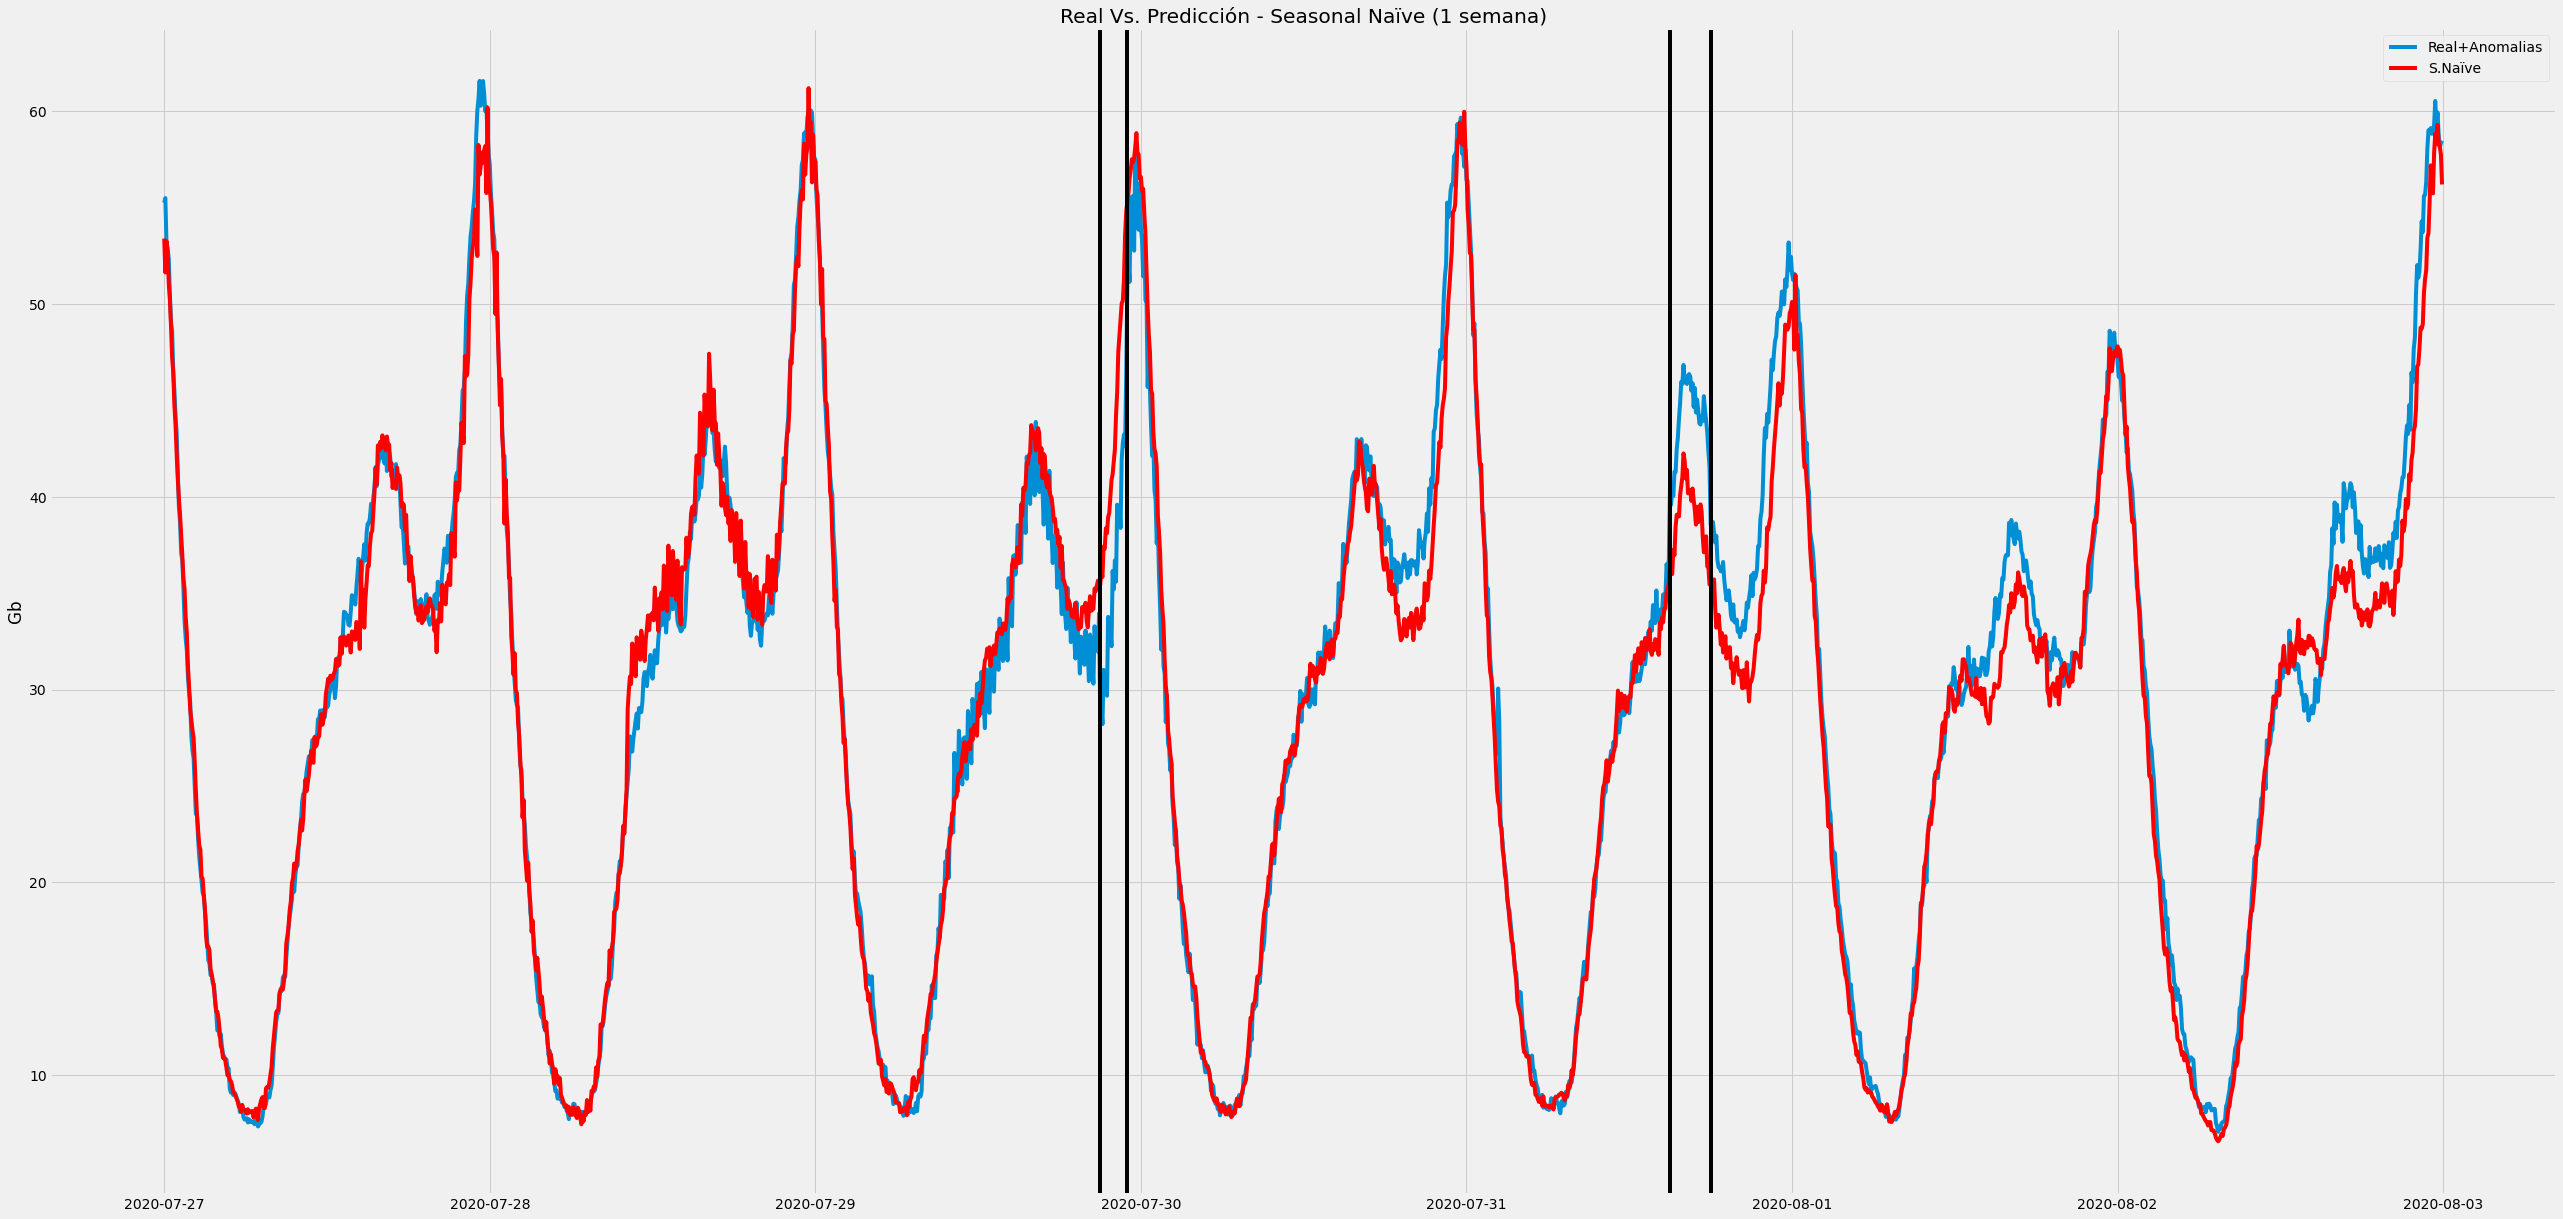

In [32]:
# plot Real vs predicción
plt.close()
plt.style.use('fivethirtyeight')
plt.figure(figsize=[40,20])
plt.ylabel('Gb')
plt.title('Real Vs. Predicción - Seasonal Naïve (1 semana)')
plt.plot(serie_test.index, serie_test['total'], label='Real+Anomalias')
plt.plot(serie_test.index, pred_snaive, color='red', label='S.Naïve')
plt.legend()
plt.axvline(x=epoch_start_anomalia1, color='black')
plt.axvline(x=epoch_end_anomalia1, color='black')
plt.axvline(x=epoch_start_anomalia2, color='black')
plt.axvline(x=epoch_end_anomalia2, color='black')
plt.show()

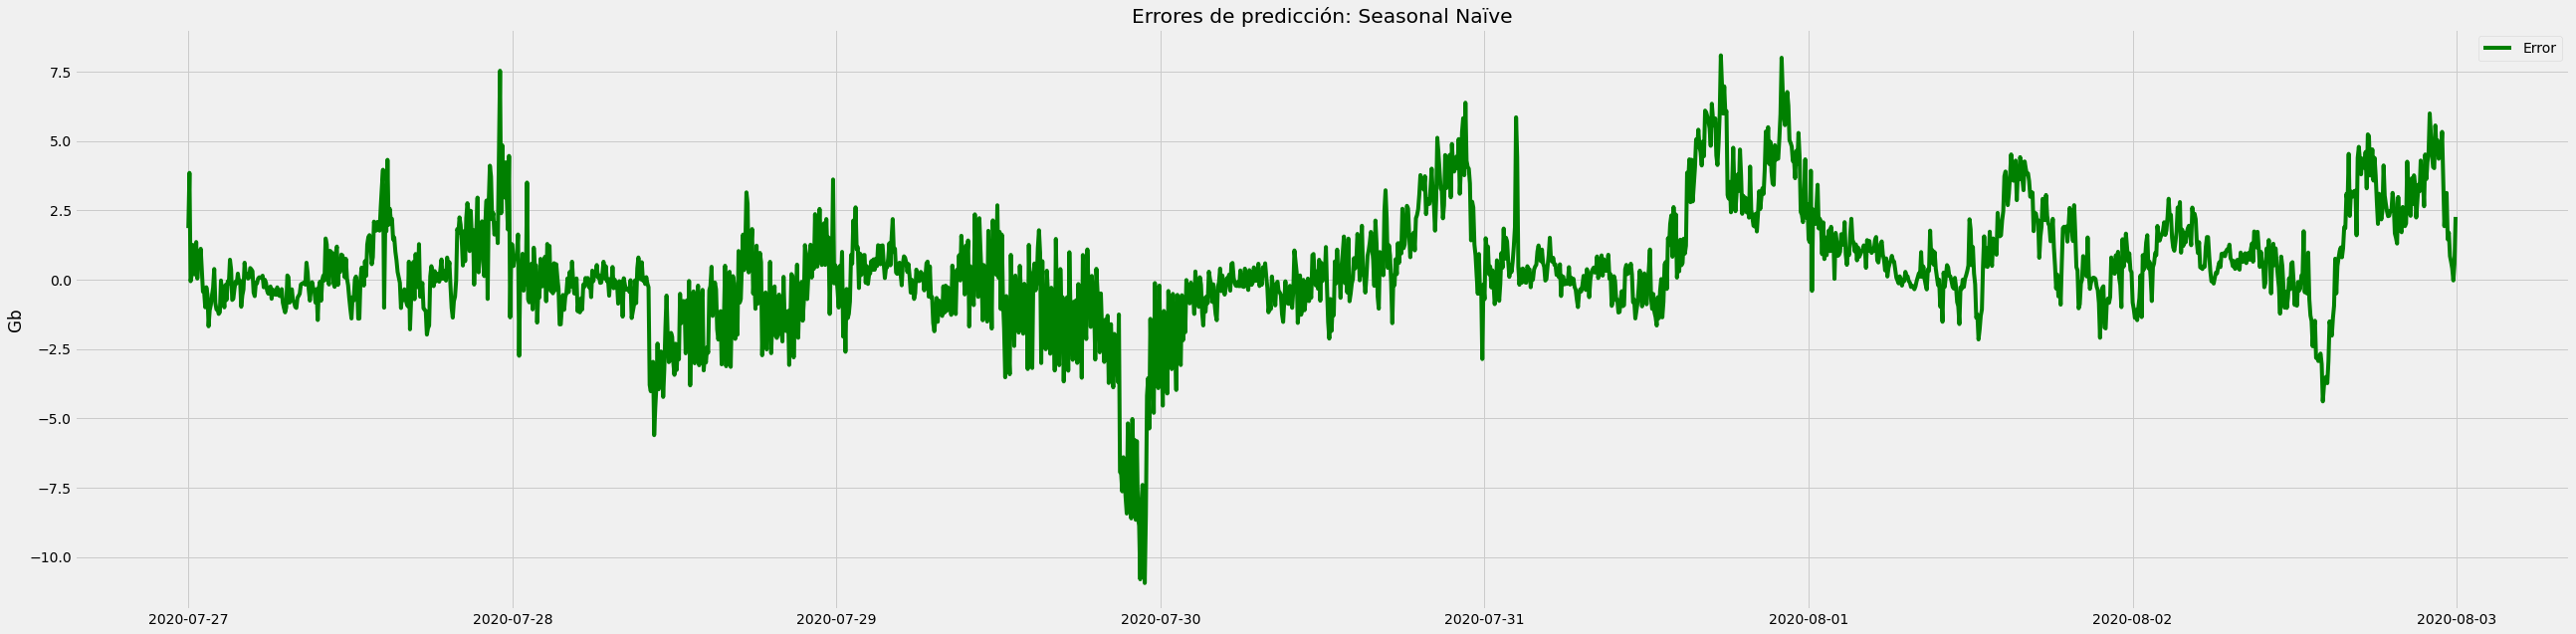

In [33]:
#Plot errores
plt.close()
plt.style.use('fivethirtyeight')
plt.figure(figsize=[40,10])
plt.ylabel('Gb')
plt.title('Errores de predicción: Seasonal Naïve')
plt.plot(serie_test.index, errores_snaive, color='green', label='Error')
#plt.axvline(x=epoch_start_anomalia1, color='black')
#plt.axvline(x=epoch_end_anomalia1, color='black')
#plt.axvline(x=epoch_start_anomalia2, color='black')
#plt.axvline(x=epoch_end_anomalia2, color='black')
plt.legend()
plt.show()

In [ ]:
#plot conjunta real, prediccion y errores
plt.close()
#fig, ax = plt.subplots(2, figsize=(20,10))
plt.style.use('fivethirtyeight')
plt.figure(figsize=[40,10])
plt.ylabel('Gb')
plt.title('Test Vs. Predicción Seasonal Naïve (1 semana)')
plt.plot(serie_test.index, serie_test['total'], label='Real')
plt.plot(serie_test.index, pred_snaive, color='red', label='S.Naïve')
plt.plot(serie_test.index, errores_snaive, color='green', label='Error')
plt.legend()
plt.show()

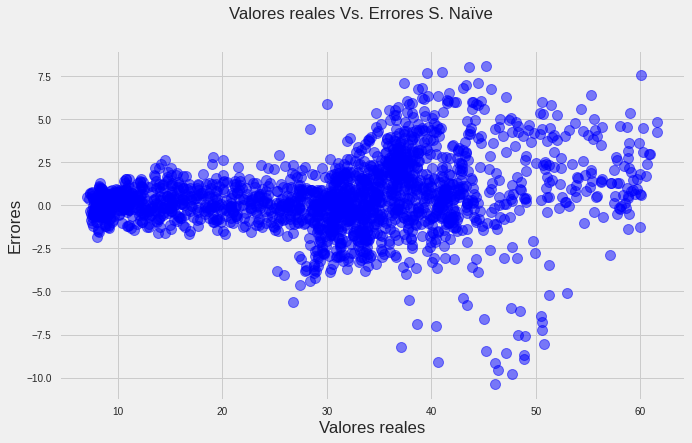

In [ ]:
#Gráfico de dispersión errores frente a valores real
plt.close()
fig, ax = plt.subplots(1, figsize=(10, 6))
fig.suptitle('Valores reales Vs. Errores S. Naïve')
# Create the Scatter Plot
ax.scatter(serie_test.values, errores_snaive, 
            color="blue",    # Color of the dots
            s=100,           # Size of the dots
            alpha=0.5,       # Alpha/transparency of the dots (1 is opaque, 0 is transparent)
            linewidths=1)    # Size of edge around the dots
plt.xlabel('Valores reales')
plt.ylabel('Errores')
plt.show()

##Naïve

Se elige cómo predicción el valor inmediatamente anterior

In [34]:
train = serie_train.values
test = serie_test.values
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	yhat = history[-1]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

pred_naive = predictions

In [35]:
#Calculo de errores y medidas de error
errores_naive =(serie_test.values - pred_naive)
print('Resultados Test Naïve')
regression_results(serie_test.values, pred_naive)

Resultados Test Naïve
MAE:  0.72
MSE:  0.96
MAPE:  2.64


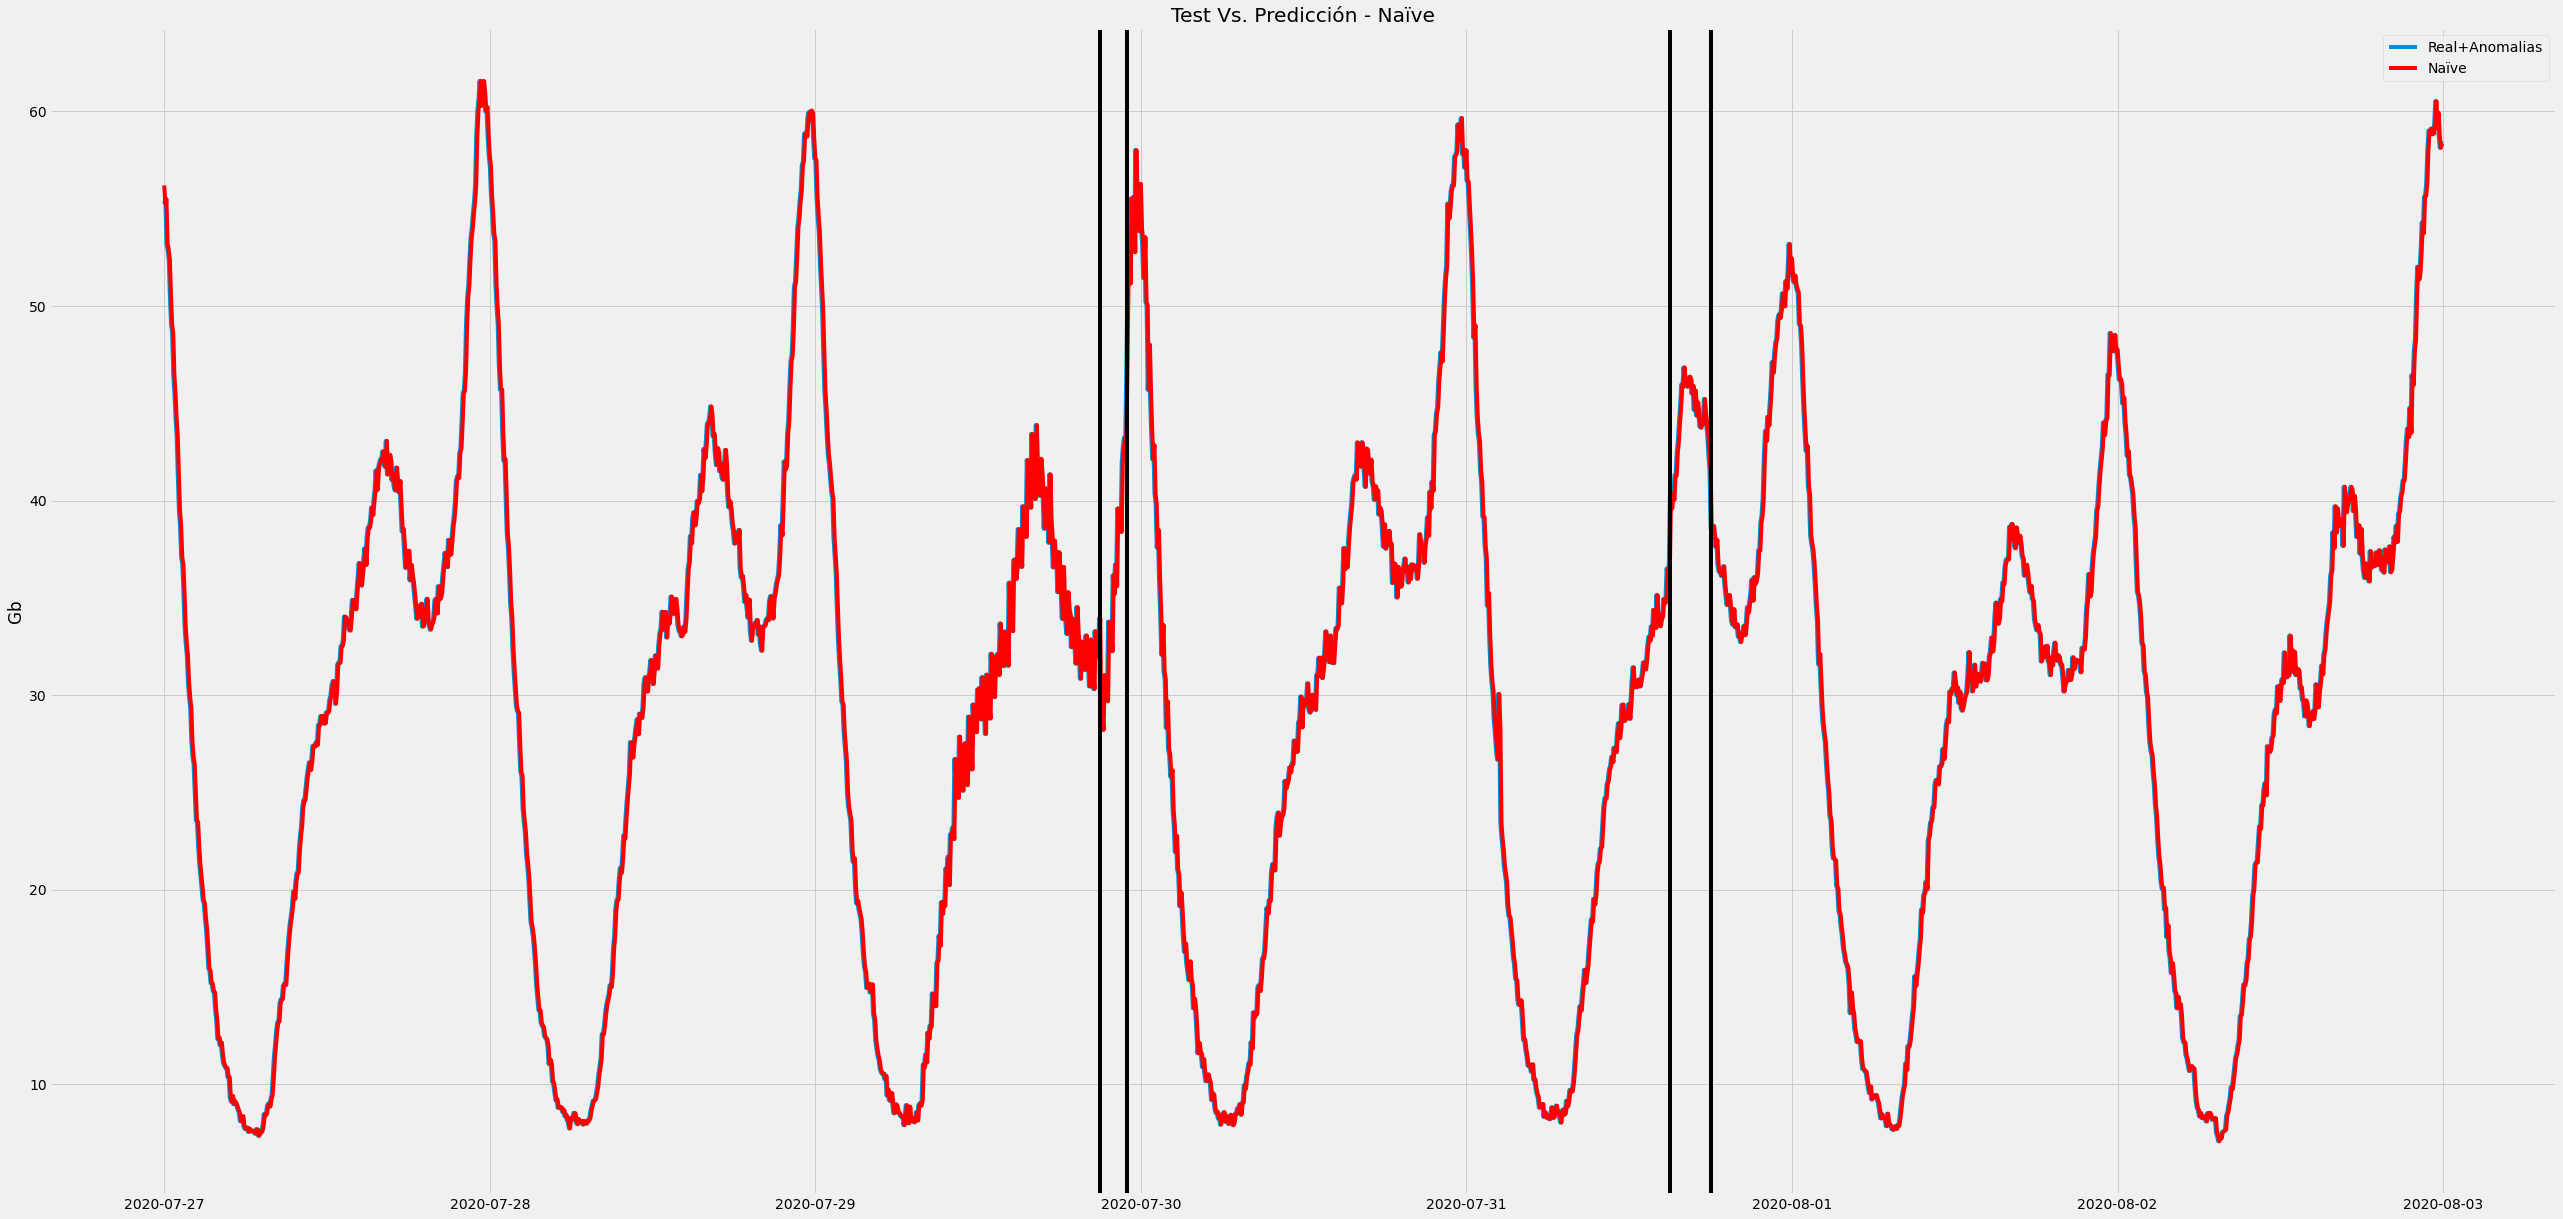

In [38]:
# plot Real Vs prediccion
plt.close()
plt.style.use('fivethirtyeight')
plt.figure(figsize=[40,20])
plt.ylabel('Gb')
plt.title('Test Vs. Predicción - Naïve')
plt.plot(serie_test.index, serie_test['total'], label='Real+Anomalias')
plt.plot(serie_test.index, pred_naive, color='red', label='Naïve')
plt.axvline(x=epoch_start_anomalia1, color='black')
plt.axvline(x=epoch_end_anomalia1, color='black')
plt.axvline(x=epoch_start_anomalia2, color='black')
plt.axvline(x=epoch_end_anomalia2, color='black')
plt.legend()
plt.show()

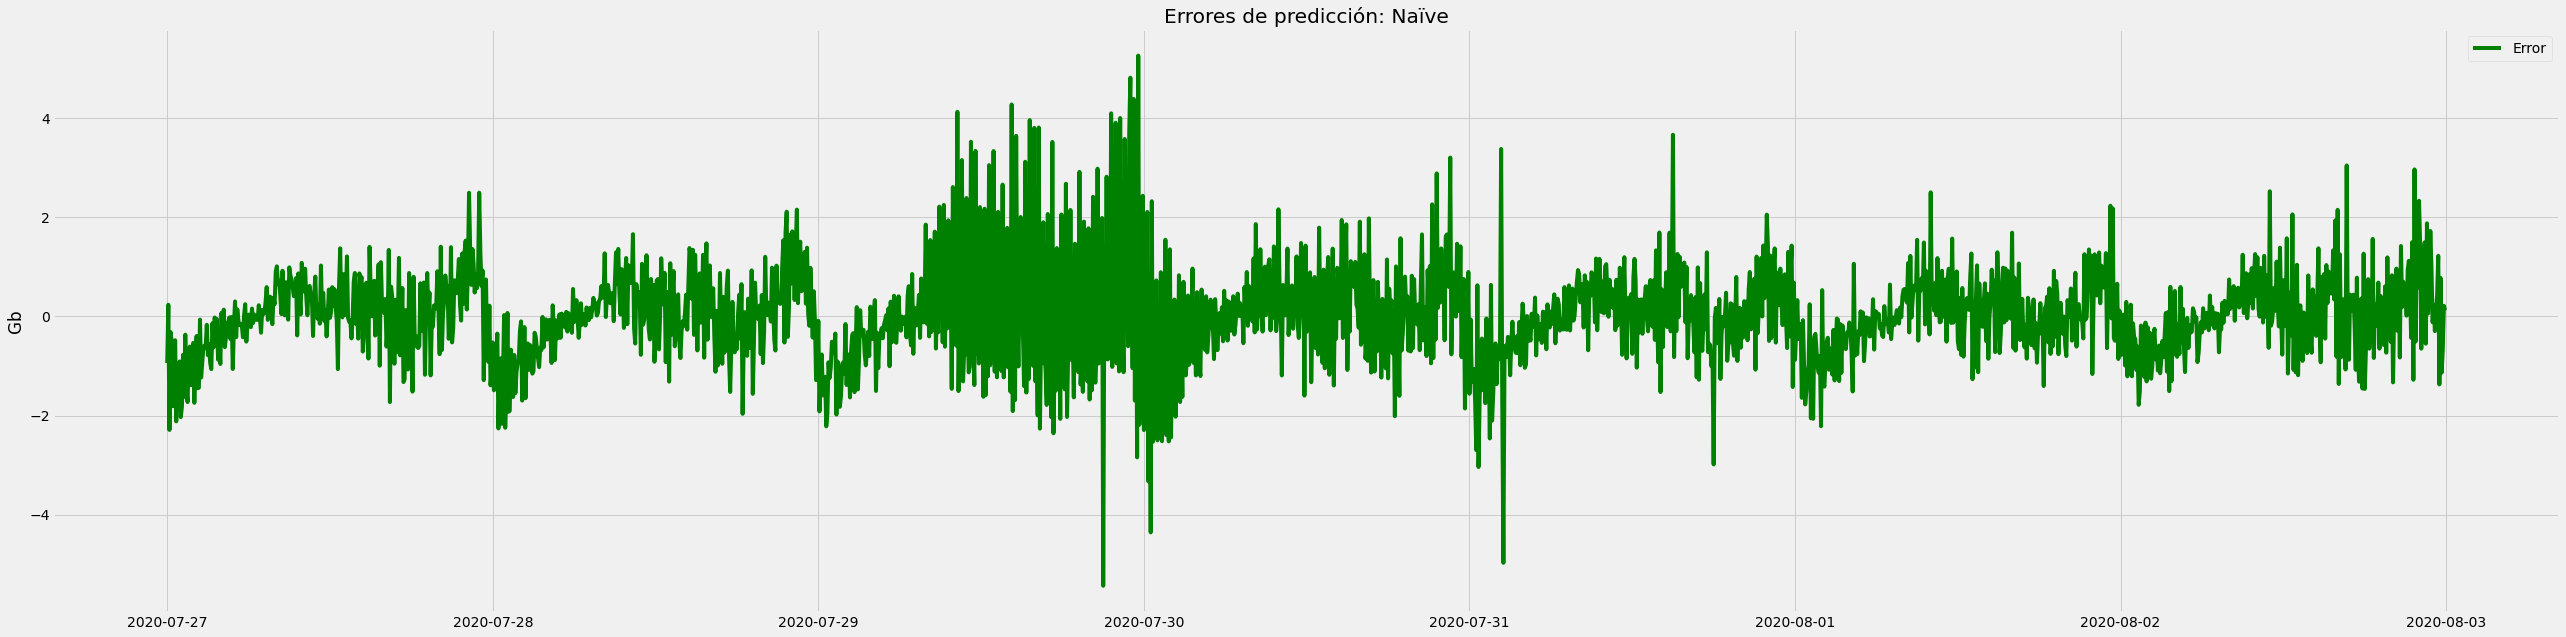

In [65]:
#Plot errores
plt.close()
plt.style.use('fivethirtyeight')
plt.figure(figsize=[40,10])
plt.ylabel('Gb')
plt.title('Errores de predicción: Naïve')
plt.plot(serie_test.index, errores_naive, color='green', label='Error')
#plt.axvline(x=epoch_start_anomalia1, color='black')
#plt.axvline(x=epoch_end_anomalia1, color='black')
#plt.axvline(x=epoch_start_anomalia2, color='black')
#plt.axvline(x=epoch_end_anomalia2, color='black')
plt.legend()
plt.show()

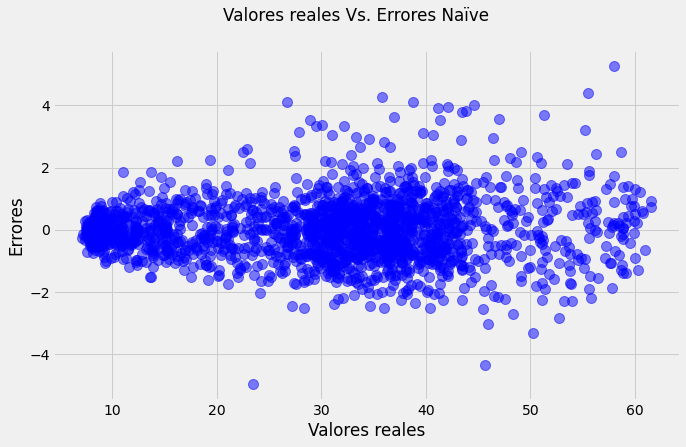

In [ ]:
#Gráfico de dispersión errores frente a valores real
plt.close()
fig, ax = plt.subplots(1, figsize=(10, 6))
fig.suptitle('Valores reales Vs. Errores Naïve')
# Create the Scatter Plot
ax.scatter(serie_test.values, errores_naive, 
            color="blue",    # Color of the dots
            s=100,           # Size of the dots
            alpha=0.5,       # Alpha/transparency of the dots (1 is opaque, 0 is transparent)
            linewidths=1)    # Size of edge around the dots
plt.xlabel('Valores reales')
plt.ylabel('Errores')
plt.show()

##ARIMA

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

Se selccionan los parámetros del modelo. 

In [63]:
p_arima = 3
d_arima = 1
q_arima = 1

In [64]:
#subserie_train = serie_train.iloc[len(serie_train)-p_arima-d_arima-q_arima:len(serie_train)]
subserie_train = serie_train.iloc[len(serie_train)-int(epoch_week/300):len(serie_train)]
#subserie_train = serie_train
train = serie_train.values
test = serie_test.values
history = [x for x in train]
predictions = list()
tiempos = list()
for t in range(len(test)):
	tiempos.append(time.time())
	if t > 0:
		print(t, round(tiempos[t]-tiempos[t-1], 2), round(tiempos[t]-tiempos[0], 2))
	model = ARIMA(history, order=(p_arima,d_arima,q_arima))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	
pred_arima = predictions

1 2.19 2.19
2 2.24 4.43
3 2.25 6.68
4 2.04 8.72
5 1.9 10.62
6 2.06 12.68
7 1.8 14.49
8 1.89 16.37
9 1.94 18.32
10 2.19 20.5
11 1.98 22.48
12 1.93 24.41
13 2.17 26.58
14 2.28 28.86
15 1.83 30.69
16 1.93 32.62
17 1.88 34.51
18 2.08 36.59
19 2.08 38.67
20 1.85 40.52
21 1.91 42.44
22 2.14 44.58
23 2.07 46.65
24 1.89 48.54
25 1.96 50.5
26 1.98 52.47
27 1.94 54.41
28 1.97 56.38
29 1.76 58.14
30 1.93 60.06
31 2.21 62.27
32 2.03 64.3
33 1.74 66.03
34 2.2 68.23
35 2.19 70.42
36 1.83 72.25
37 1.98 74.23
38 1.81 76.05
39 2.01 78.06
40 1.87 79.93
41 1.85 81.77
42 1.89 83.66
43 2.07 85.73
44 1.94 87.67
45 2.07 89.74
46 1.73 91.46
47 2.28 93.74
48 2.47 96.21
49 2.04 98.25
50 2.18 100.42
51 1.94 102.36
52 2.01 104.37
53 1.88 106.25
54 1.84 108.09
55 1.96 110.05
56 2.19 112.25
57 1.99 114.23
58 1.99 116.23
59 1.88 118.11
60 1.92 120.03
61 2.17 122.21
62 2.08 124.29
63 2.16 126.45
64 1.88 128.33
65 2.27 130.6
66 1.77 132.37
67 1.83 134.2
68 1.97 136.17
69 1.86 138.04
70 1.93 139.96
71 2.2 142.16
72 2.1

In [75]:
#Calculo de errores y medidas de error
errores_arima =(serie_test.values - pred_arima)
print('Resultados Test ARIMA(', p_arima, ',', d_arima, ',', q_arima, ')')
regression_results(serie_test.values, pred_arima)
print('Duración total [sg]: ',round(tiempos[-1]-tiempos[0], 0))

Resultados Test ARIMA( 3 , 1 , 1 )
MAE:  0.6
MSE:  0.71
MAPE:  2.21
Duración total [sg]:  4968.0


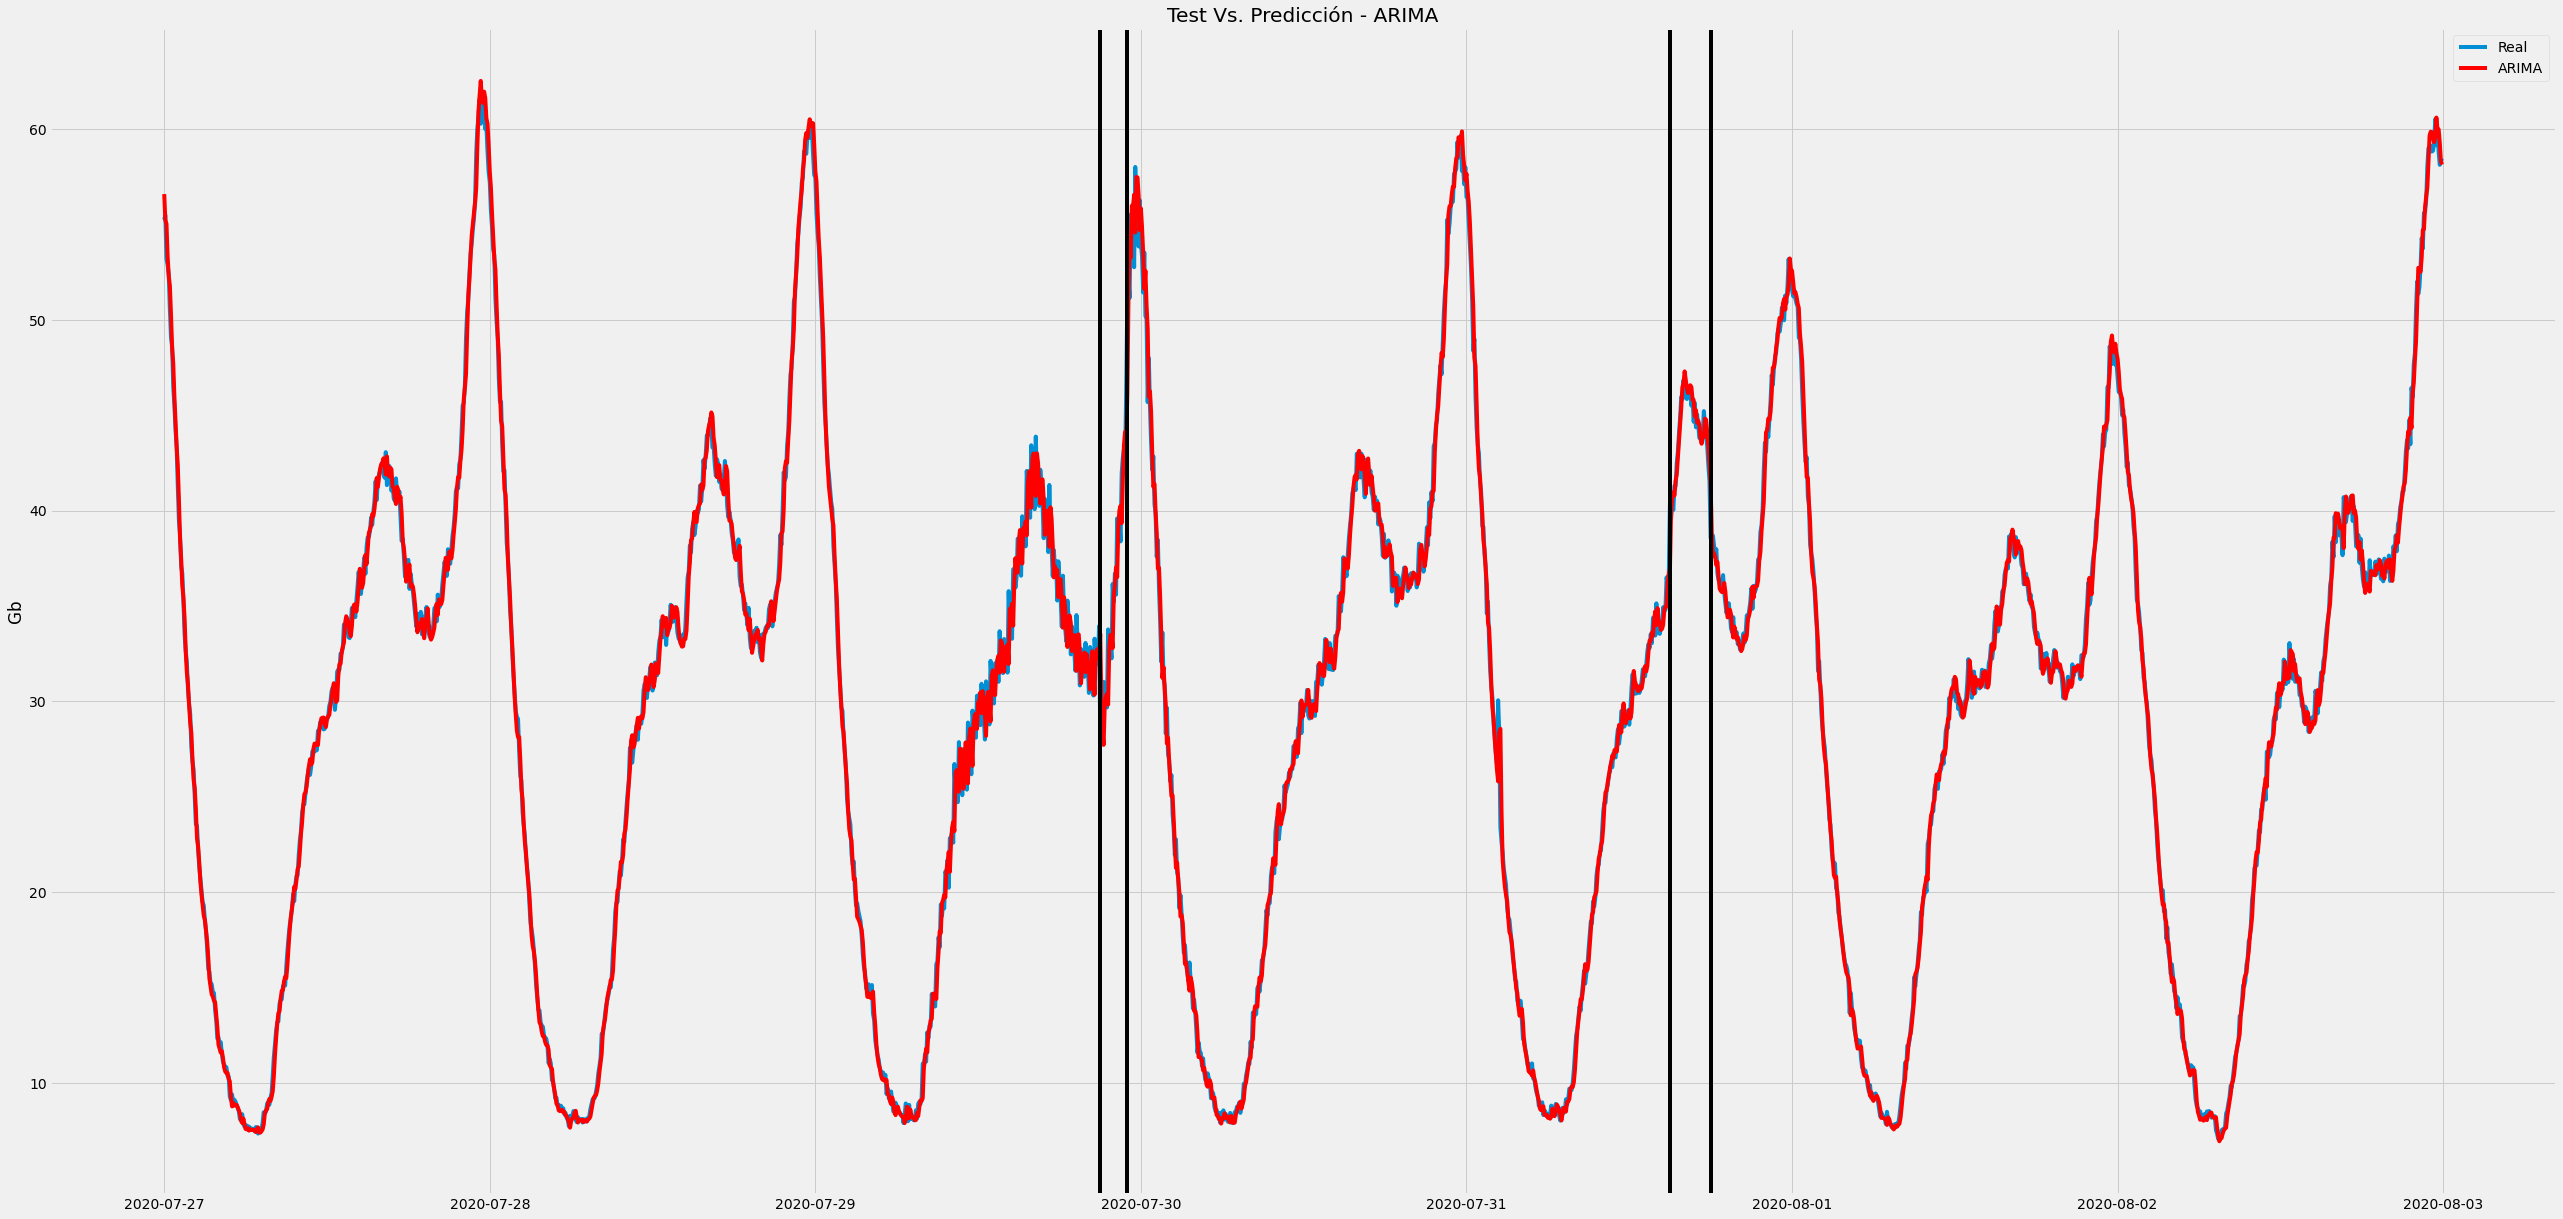

In [76]:
# plot Real Vs prediccion
plt.close()
plt.style.use('fivethirtyeight')
plt.figure(figsize=[40,20])
plt.ylabel('Gb')
plt.title('Test Vs. Predicción - ARIMA')
plt.plot(serie_test.index, serie_test['total'], label='Real')
plt.plot(serie_test.index, pred_arima, color='red', label='ARIMA')
plt.axvline(x=epoch_start_anomalia1, color='black')
plt.axvline(x=epoch_end_anomalia1, color='black')
plt.axvline(x=epoch_start_anomalia2, color='black')
plt.axvline(x=epoch_end_anomalia2, color='black')
plt.legend()
plt.show()

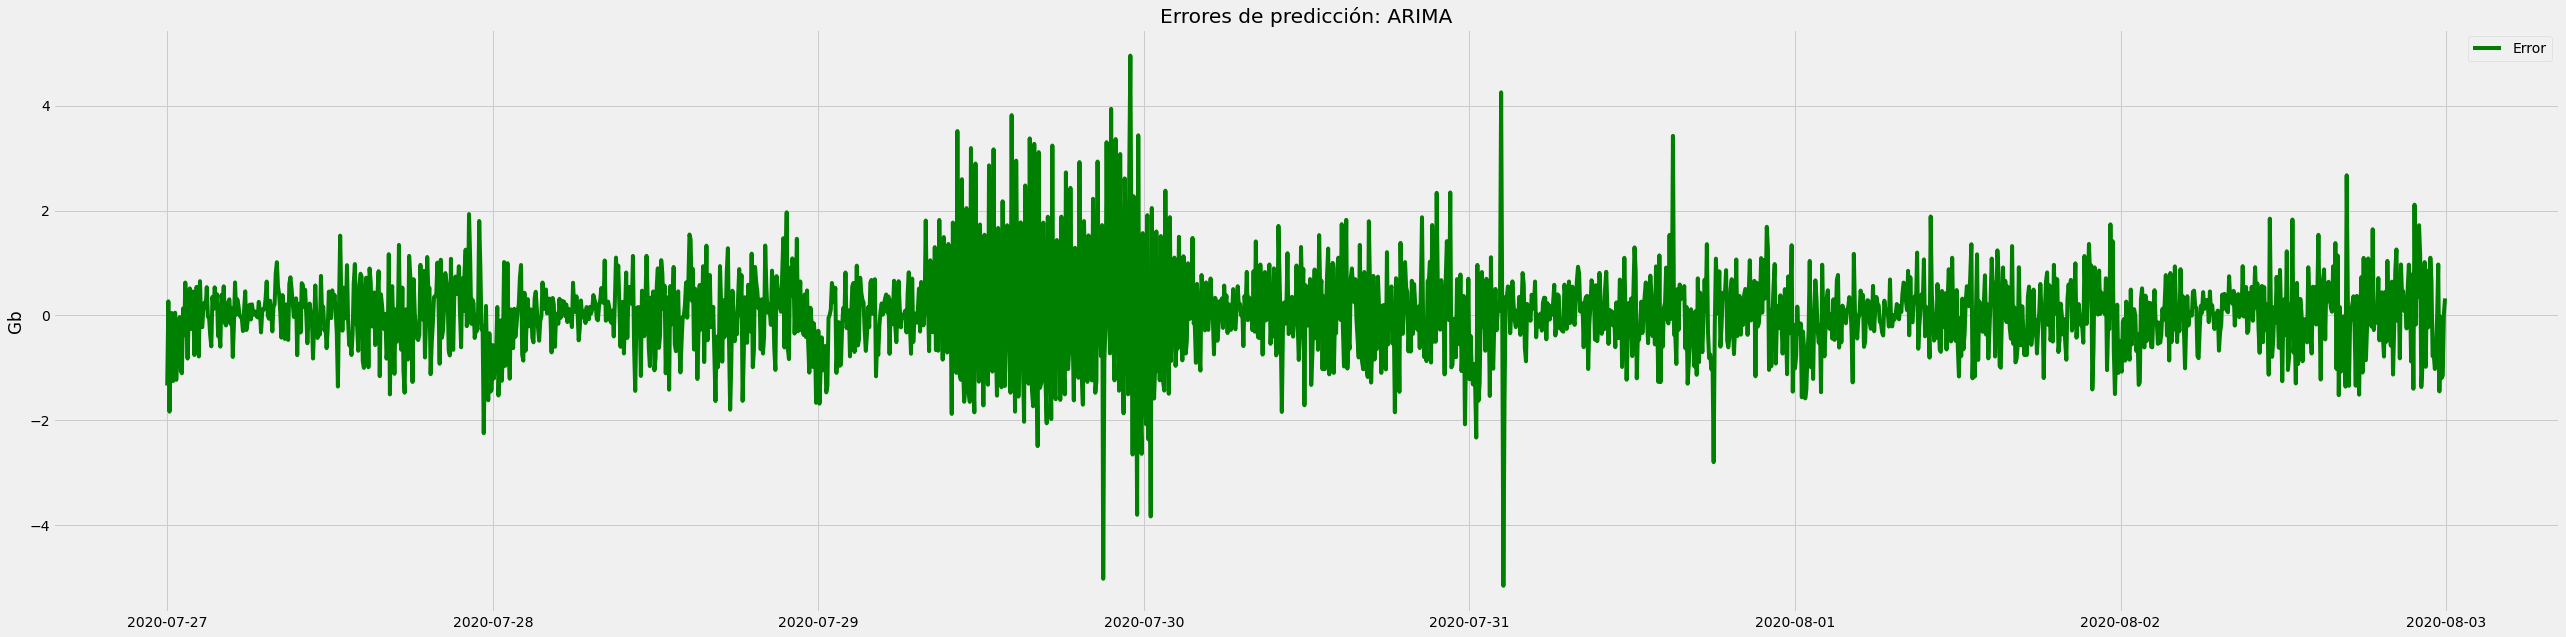

In [78]:
#Plot errores
plt.close()
plt.style.use('fivethirtyeight')
plt.figure(figsize=[40,10])
plt.ylabel('Gb')
plt.title('Errores de predicción: ARIMA')
plt.plot(serie_test.index, errores_arima, color='green', label='Error')
#plt.axvline(x=epoch_start_anomalia1, color='black')
#plt.axvline(x=epoch_end_anomalia1, color='black')
#plt.axvline(x=epoch_start_anomalia2, color='black')
#plt.axvline(x=epoch_end_anomalia2, color='black')
plt.legend()
plt.show()

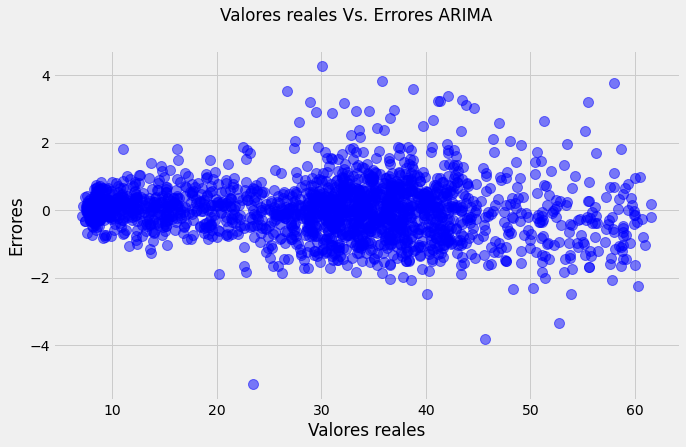

In [ ]:
#Gráfico de dispersión errores frente a valores real
plt.close()
fig, ax = plt.subplots(1, figsize=(10, 6))
fig.suptitle('Valores reales Vs. Errores ARIMA')
# Create the Scatter Plot
ax.scatter(serie_test.values, errores_arima, 
            color="blue",    # Color of the dots
            s=100,           # Size of the dots
            alpha=0.5,       # Alpha/transparency of the dots (1 is opaque, 0 is transparent)
            linewidths=1)    # Size of edge around the dots
plt.xlabel('Valores reales')
plt.ylabel('Errores')
plt.show()

##Prophet

https://facebook.github.io/prophet/docs/quick_start.html

En primer lugar hay que trasnformar el dataset al formato necesario para el API

In [40]:
data_train = {'ds':serie_train.index, 'y':serie_train['total']}
train_prophet = pd.DataFrame(data=data_train)
train_prophet.tail()

ds          y
timeStamp                                         
2020-07-26 23:35:00 2020-07-26 23:35:00  59.284297
2020-07-26 23:40:00 2020-07-26 23:40:00  58.385666
2020-07-26 23:45:00 2020-07-26 23:45:00  58.152342
2020-07-26 23:50:00 2020-07-26 23:50:00  57.767017
2020-07-26 23:55:00 2020-07-26 23:55:00  56.195818

In [41]:
data_test = {'ds':serie_test.index, 'y':serie_test['total']}
test_prophet = pd.DataFrame(data=data_test)
test_prophet.tail()

ds          y
timeStamp                                         
2020-08-02 23:35:00 2020-08-02 23:35:00  59.931283
2020-08-02 23:40:00 2020-08-02 23:40:00  58.796034
2020-08-02 23:45:00 2020-08-02 23:45:00  58.127769
2020-08-02 23:50:00 2020-08-02 23:50:00  58.340047
2020-08-02 23:55:00 2020-08-02 23:55:00  58.463460

Entrenamiento

In [42]:
tiempos_training = list()
tiempos_training.append(time.time())
m = Prophet(growth='linear', n_changepoints=8, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True)
m.fit(train_prophet)
tiempos_training.append(time.time())
print('Duración training [sg]: ',round(tiempos_training[-1]-tiempos_training[0], 0))

Duración training [sg]:  4.0


Predicción

In [43]:
future = {'ds':serie_test.index}
future_prophet = pd.DataFrame(data=future)
tiempos_pred = list()
tiempos_pred.append(time.time())
forecast = m.predict(future_prophet)
tiempos_pred.append(time.time())
print('Duración predicción [sg]: ',round(tiempos_pred[-1]-tiempos_pred[0], 0))

Duración predicción [sg]:  3.0


In [44]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
2011 2020-08-02 23:35:00  52.089494   44.136850   59.519472
2012 2020-08-02 23:40:00  51.966528   43.836278   59.377135
2013 2020-08-02 23:45:00  51.785898   43.640717   58.977419
2014 2020-08-02 23:50:00  51.547905   43.442681   59.045528
2015 2020-08-02 23:55:00  51.253112   43.375686   58.436137

In [45]:
forecast.head()

ds      trend  ...  multiplicative_terms_upper       yhat
0 2020-07-27 00:00:00  29.524047  ...                         0.0  50.471020
1 2020-07-27 00:05:00  29.524261  ...                         0.0  50.065354
2 2020-07-27 00:10:00  29.524475  ...                         0.0  49.606108
3 2020-07-27 00:15:00  29.524689  ...                         0.0  49.094837
4 2020-07-27 00:20:00  29.524903  ...                         0.0  48.533319

[5 rows x 19 columns]

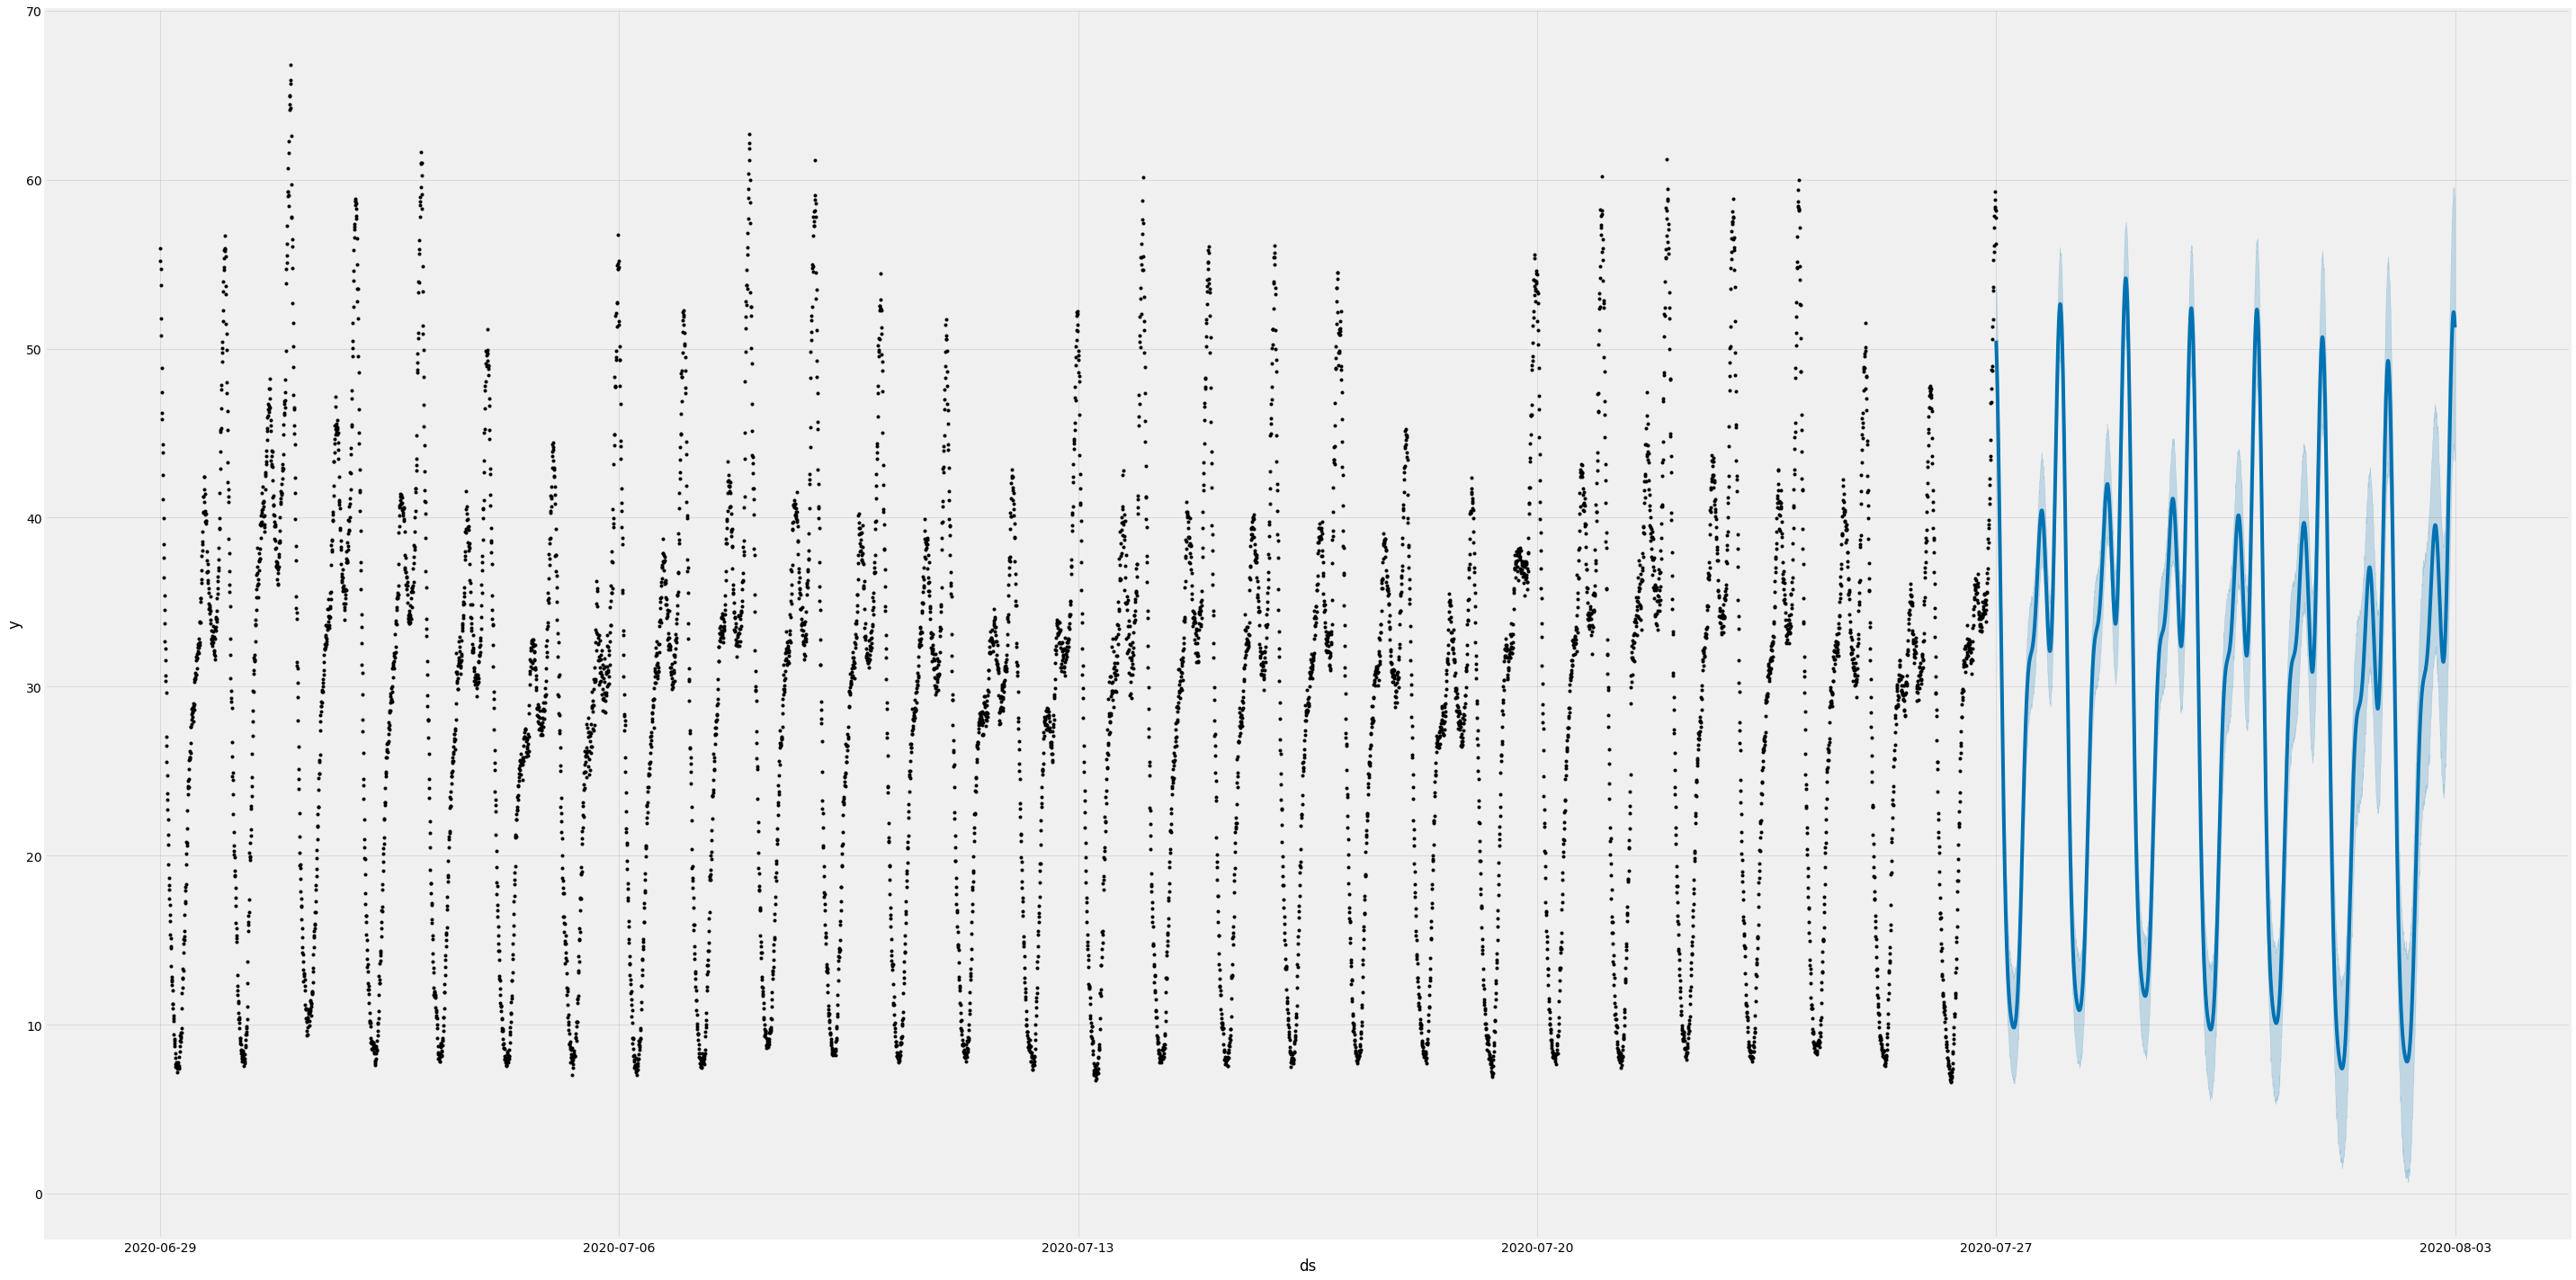

In [46]:
fig1 = m.plot(forecast, figsize=(40,20))

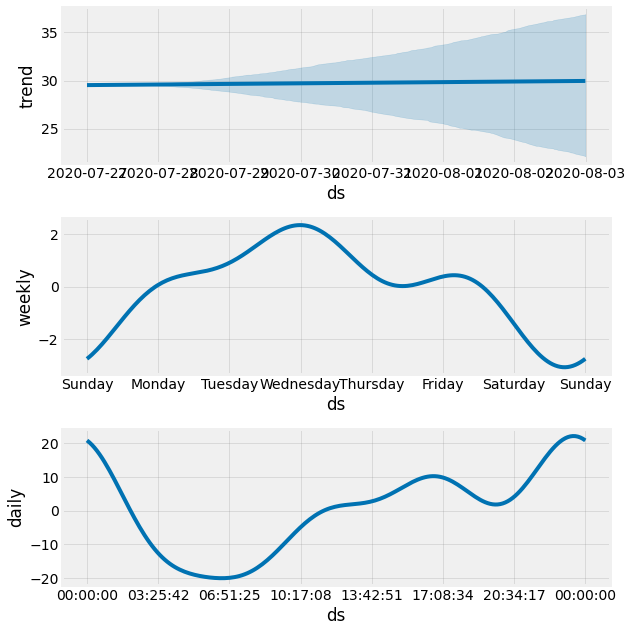

In [47]:
fig2 = m.plot_components(forecast)

In [48]:
errores_prophet=serie_test.values - forecast[['yhat']]
print('Resultados Test FB Prophet')
regression_results(serie_test.values, forecast[['yhat']])
print('Duración total [sg]: ',round(tiempos_training[-1]-tiempos_training[0] + tiempos_pred[-1]-tiempos_pred[0], 0))

Resultados Test FB Prophet
MAE:  2.16
MSE:  7.76
MAPE:  9.39
Duración total [sg]:  7.0


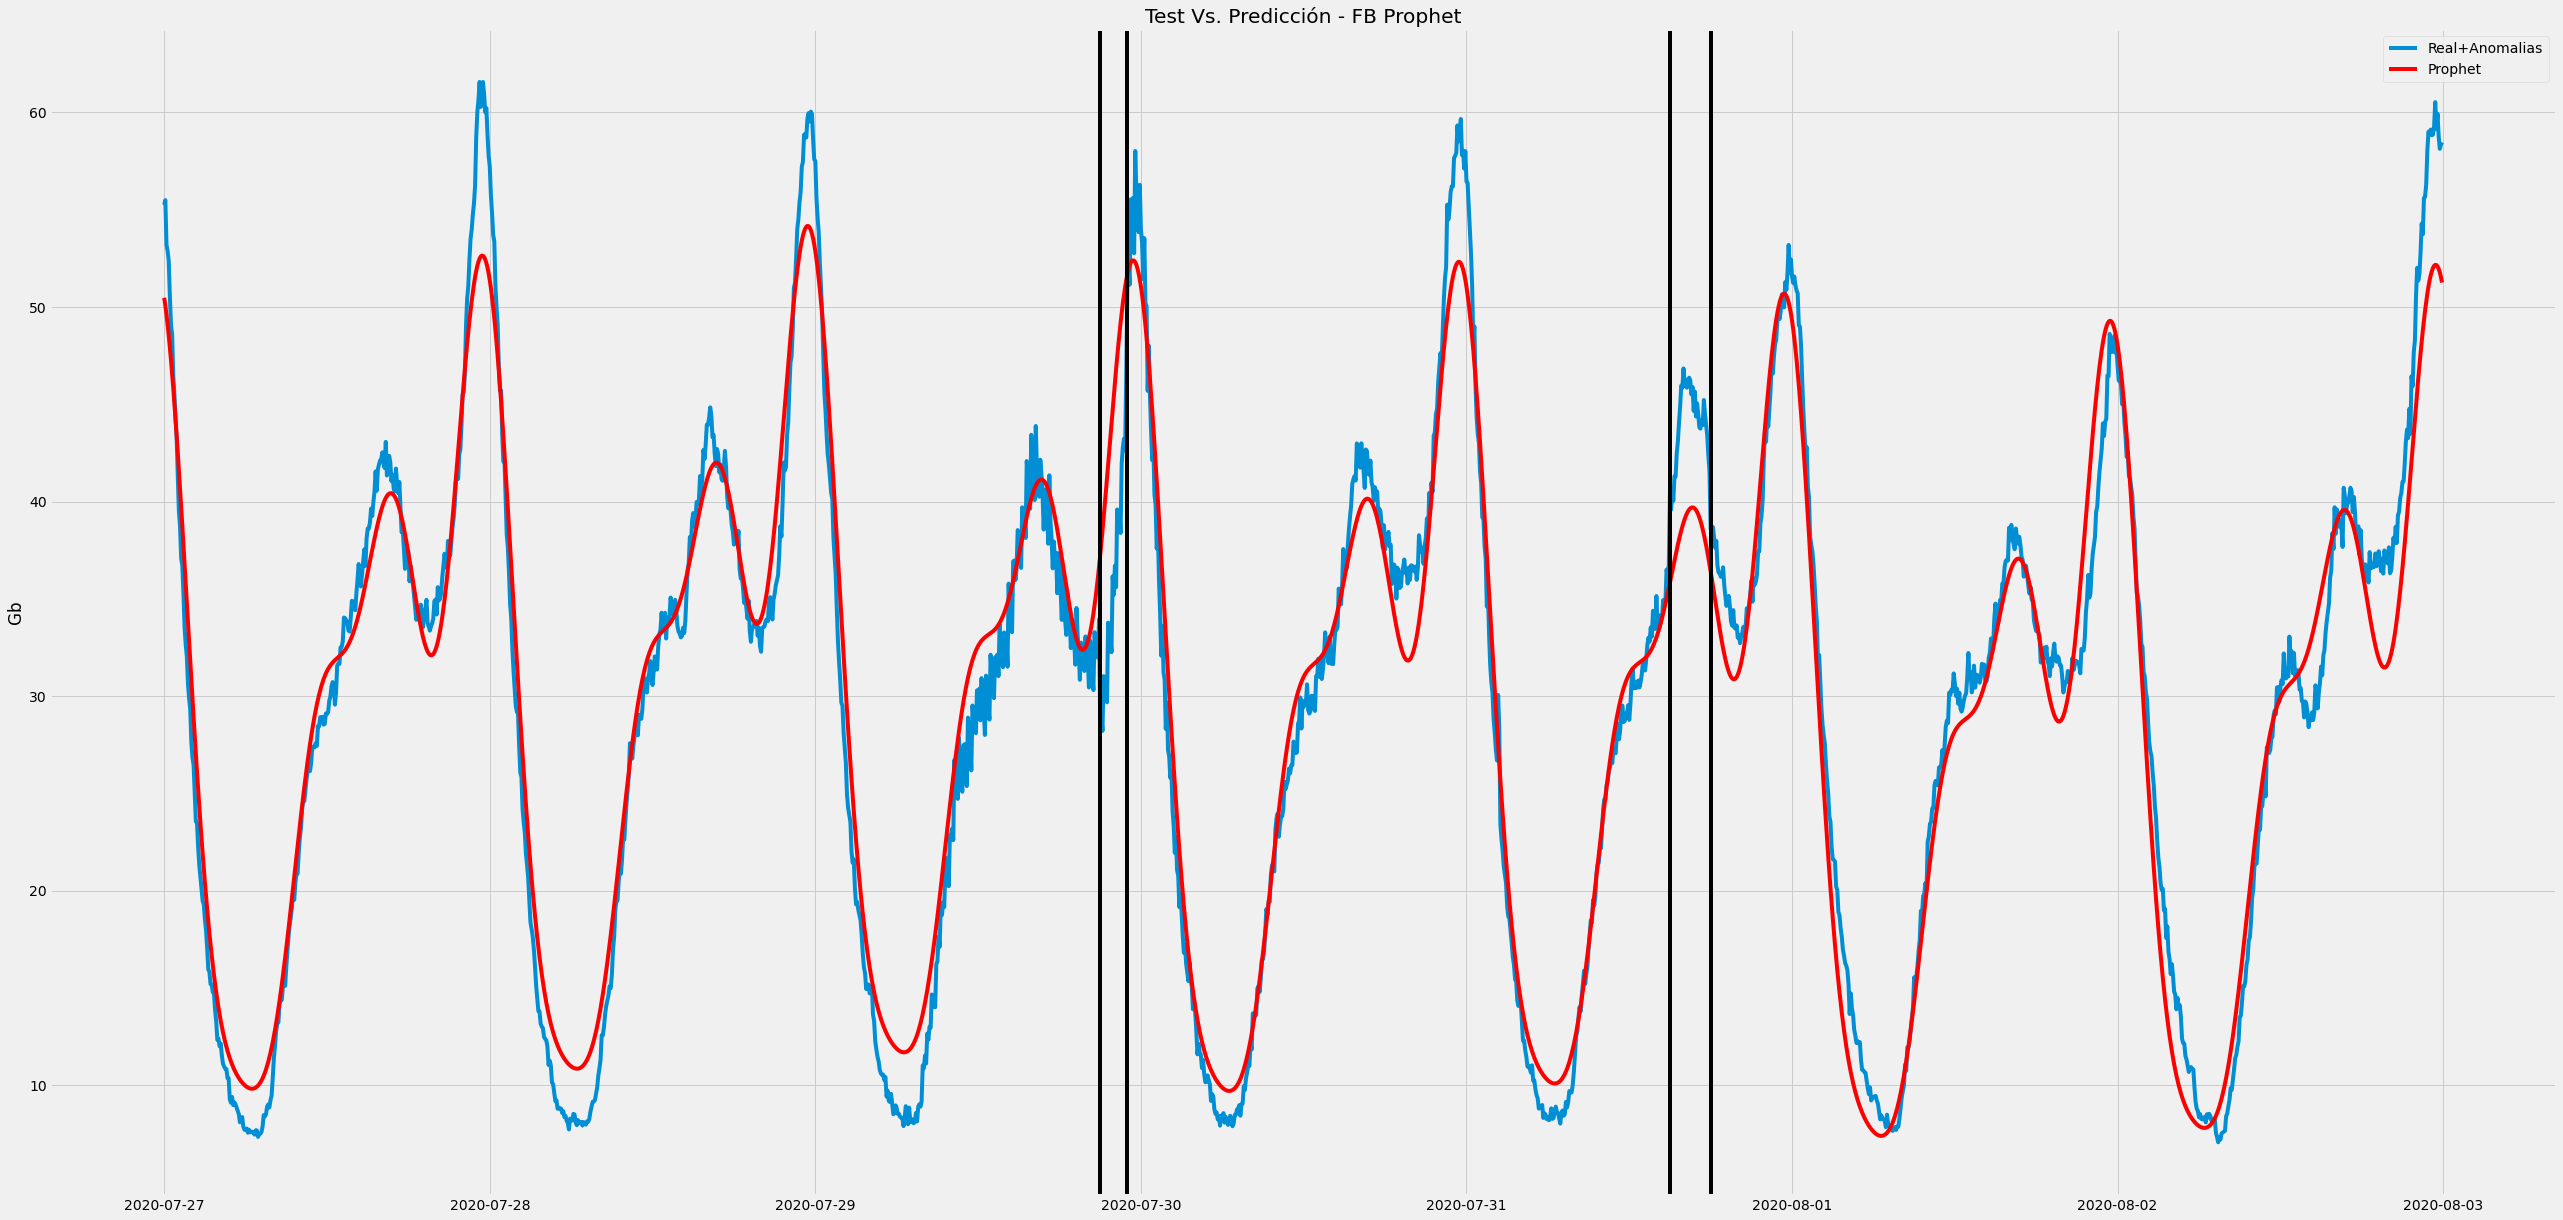

In [50]:
# plot Real Vs prediccion
plt.close()
plt.style.use('fivethirtyeight')
plt.figure(figsize=[40,20])
plt.ylabel('Gb')
plt.title('Test Vs. Predicción - FB Prophet')
plt.plot(serie_test.index, serie_test.values, label='Real+Anomalias')
plt.plot(serie_test.index, forecast[['yhat']].values, color='red', label='Prophet')
plt.axvline(x=epoch_start_anomalia1, color='black')
plt.axvline(x=epoch_end_anomalia1, color='black')
plt.axvline(x=epoch_start_anomalia2, color='black')
plt.axvline(x=epoch_end_anomalia2, color='black')
plt.legend()
plt.show()

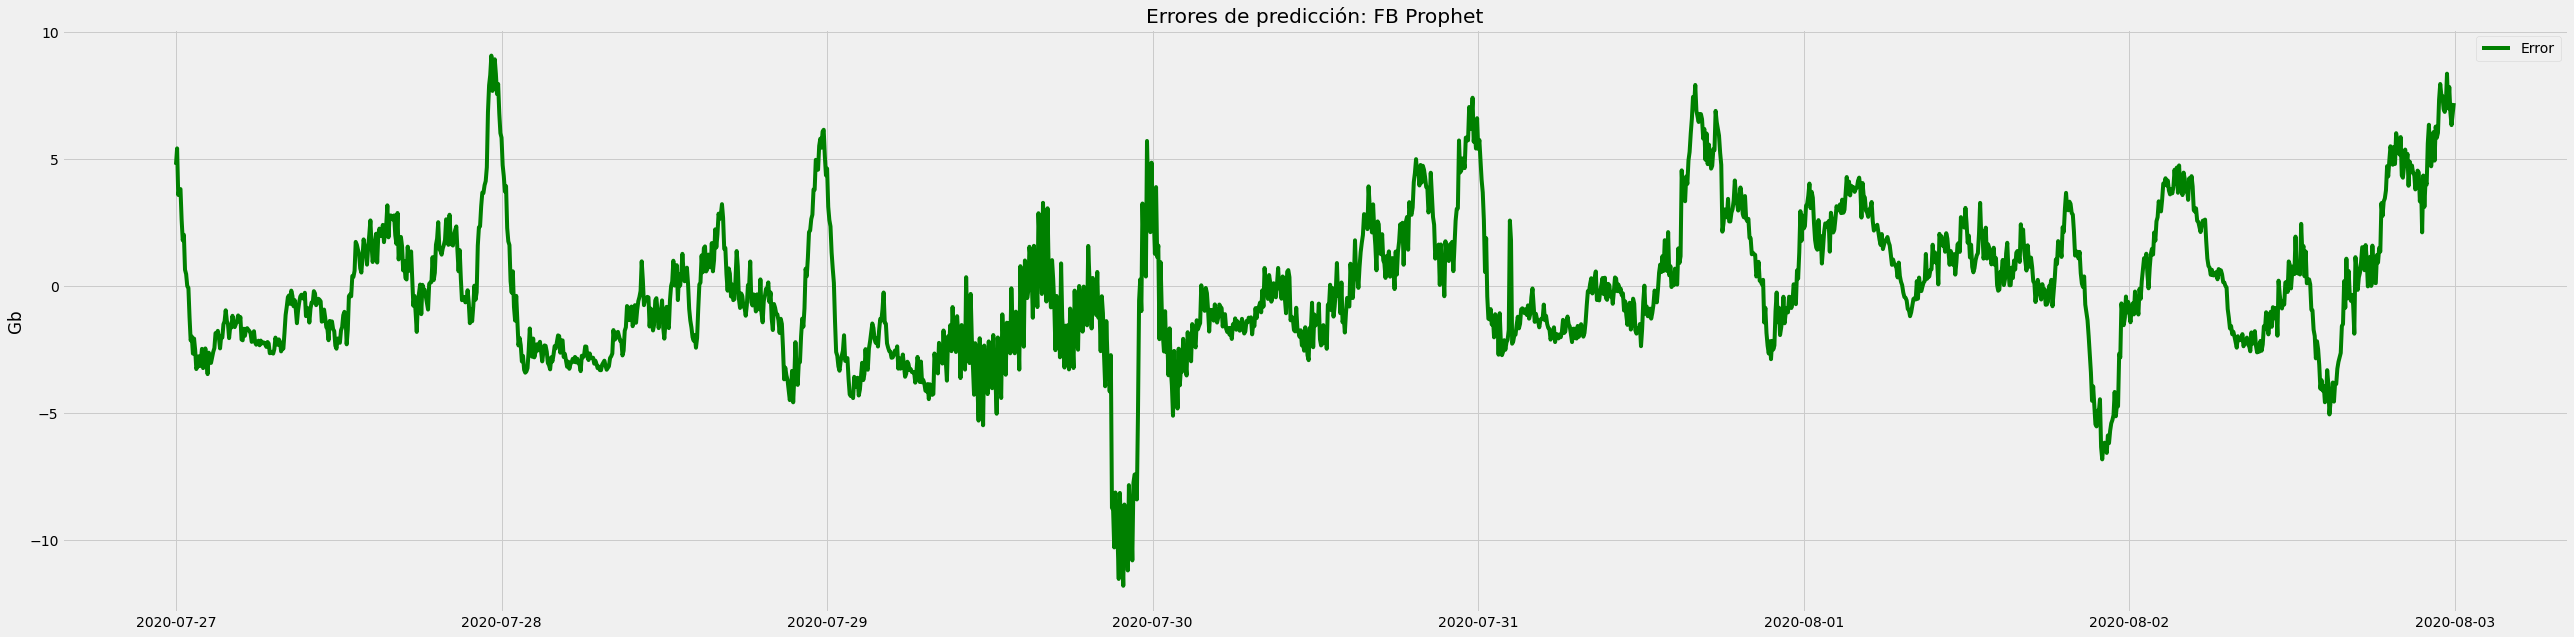

In [79]:
#Plot errores
plt.close()
plt.style.use('fivethirtyeight')
plt.figure(figsize=[40,10])
plt.ylabel('Gb')
plt.title('Errores de predicción: FB Prophet')
plt.plot(serie_test.index, errores_prophet, color='green', label='Error')
#plt.axvline(x=epoch_start_anomalia1, color='black')
#plt.axvline(x=epoch_end_anomalia1, color='black')
#plt.axvline(x=epoch_start_anomalia2, color='black')
#plt.axvline(x=epoch_end_anomalia2, color='black')
plt.legend()
plt.show()

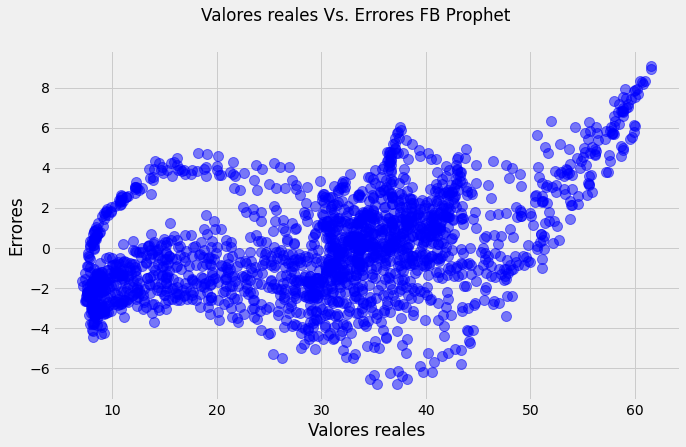

In [ ]:
#Gráfico de dispersión errores frente a valores real
plt.close()
fig, ax = plt.subplots(1, figsize=(10, 6))
fig.suptitle('Valores reales Vs. Errores FB Prophet')
# Create the Scatter Plot
ax.scatter(serie_test.values, errores_prophet, 
            color="blue",    # Color of the dots
            s=100,           # Size of the dots
            alpha=0.5,       # Alpha/transparency of the dots (1 is opaque, 0 is transparent)
            linewidths=1)    # Size of edge around the dots
plt.xlabel('Valores reales')
plt.ylabel('Errores')
plt.show()

Comparación del real con yhat_lower e yhat_upper

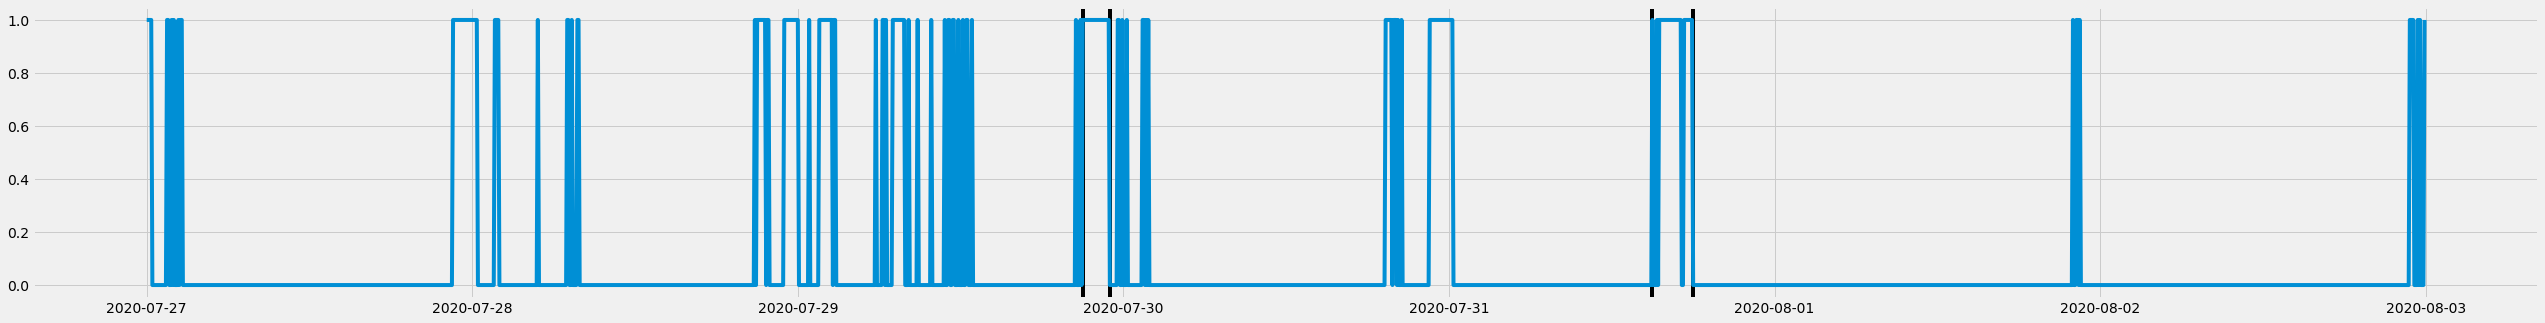

In [53]:
pred_prophet_low = (serie_test.values < forecast[['yhat_lower']].values) 
pred_prophet_up = (serie_test.values > forecast[['yhat_upper']].values)
pred_prophet_out = (serie_test.values < forecast[['yhat_lower']].values) + (serie_test.values > forecast[['yhat_upper']].values)
plt.figure(figsize=[40,5])
plt.axvline(x=epoch_start_anomalia1, color='black')
plt.axvline(x=epoch_end_anomalia1, color='black')
plt.axvline(x=epoch_start_anomalia2, color='black')
plt.axvline(x=epoch_end_anomalia2, color='black')
plt.plot(serie_test.index, pred_prophet_out==True, )

##LSTM

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/

Preparar los dataset para la red

In [54]:
# fix random seed for reproducibility
np.random.seed(7)
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [55]:
train_lstm = pd.DataFrame(data=serie_train)
test_lstm = pd.DataFrame(data=serie_test)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train_lstm)
test_norm = scaler.fit_transform(test_lstm)

In [56]:
# reshape into X=t and Y=t+1
look_back = 100
trainX, trainY = create_dataset(train_norm, look_back)
testX, testY = create_dataset(test_norm, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Entrenamiento

In [57]:
#Entrenar el modelo
units=16
epochs=100
batch_size=100
#Cuenta tiempos - Inicio
tiempos_training = list()
tiempos_training.append(time.time())
# create and fit the LSTM network
model = Sequential()
#model.add(LSTM(units=32, return_sequences=True, input_shape=(1, look_back)))
#model.add(Dropout(0.1))
#model.add(LSTM(units=16, return_sequences=True, input_shape=(1, look_back)))
#model.add(Dropout(0.1))
model.add(LSTM(units=units, input_shape=(1, look_back)))
#model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)
#Cuenta tiempos - Fin
tiempos_training.append(time.time())
print('Duración training [sg]: ',round(tiempos_training[-1]-tiempos_training[0], 0))

Duración training [sg]:  14.0


Predicción

In [58]:
#Cuenta tiempos - Inicio
tiempos_pred = list()
tiempos_pred.append(time.time())
#print('epoch = %.f' % (epochs), ', look_back = %.0f' % (look_back))
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
#print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
#print('Test Score: %.2f RMSE' % (testScore))
#Cuenta tiempos - Fin
tiempos_pred.append(time.time())
print('Duración predicción [sg]: ',round(tiempos_pred[-1]-tiempos_pred[0], 0))

Duración predicción [sg]:  1.0


In [59]:
errores_lstm = testY[0] - testPredict[:,0]
print('Resultados Test LSTM')
regression_results(testY[0], testPredict[:,0])
print('Duración total [sg]: ',round(tiempos_training[-1]-tiempos_training[0] + tiempos_pred[-1]-tiempos_pred[0], 0))

Resultados Test LSTM
MAE:  0.59
MSE:  0.59
MAPE:  2.3
Duración total [sg]:  15.0


In [60]:
epoch_start_anomalia1 = 1596056400
epoch_end_anomalia1 = 1596063600
epoch_start_anomalia2 = 1596207600
epoch_end_anomalia2 = 1596218400
start_anomalia1 = int((epoch_start_anomalia1 - epoch_week31_start)/300)
end_anomalia1 = int((epoch_end_anomalia1 - epoch_week31_start)/300)

In [61]:
# plot Real Vs prediccion
plt.close()
plt.style.use('fivethirtyeight')
plt.figure(figsize=[40,20])
plt.ylabel('Gb')
plt.title('Test Vs. Predicción - LSTM')
plt.plot(testY[0], label='Real')
plt.plot(testPredict[:,0], color='red', label='LSTM')
plt.legend()
plt.show()

In [62]:
#Plot errores
plt.close()
plt.style.use('fivethirtyeight')
plt.figure(figsize=[40,10])
plt.ylabel('Gb')
plt.title('Errores de predicción: LSTM')
plt.plot(errores_lstm, color='green', label='Error')
plt.legend()
plt.show()

In [ ]:
#Gráfico de dispersión errores frente a valores real
plt.close()
fig, ax = plt.subplots(1, figsize=(10, 6))
fig.suptitle('Valores reales Vs. Errores LSTM')
# Create the Scatter Plot
ax.scatter(testY[0], errores_lstm, 
            color="blue",    # Color of the dots
            s=100,           # Size of the dots
            alpha=0.5,       # Alpha/transparency of the dots (1 is opaque, 0 is transparent)
            linewidths=1)    # Size of edge around the dots
plt.xlabel('Valores reales')
plt.ylabel('Errores')
plt.show()